# Imports

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
import warnings

# Ignore warnings for cleaner output
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')


# Load Datasets

In [14]:
# Import all datasets from the Olist dataset
orders = pd.read_csv('olist_dataset/olist_orders_dataset.csv')
customers = pd.read_csv('olist_dataset/olist_customers_dataset.csv')
order_items = pd.read_csv('olist_dataset/olist_order_items_dataset.csv')
products = pd.read_csv('olist_dataset/olist_products_dataset.csv')
sellers = pd.read_csv('olist_dataset/olist_sellers_dataset.csv')
order_reviews = pd.read_csv('olist_dataset/olist_order_reviews_dataset.csv')
order_payments = pd.read_csv('olist_dataset/olist_order_payments_dataset.csv')
geolocation = pd.read_csv('olist_dataset/olist_geolocation_dataset.csv')

# Data Validation

In [15]:
# Initial steps and Data Validation
# Define lists with expected columns
customer_cols = ['customer_id', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state']
geoloc_cols = ['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng', 'geolocation_city', 'geolocation_state']
order_items_cols = ['order_id', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value']
order_payments_cols = ['order_id', 'payment_sequential', 'payment_type', 'payment_installments', 'payment_value']
order_reviews_cols = ['review_id', 'order_id', 'review_score', 'review_comment_title', 'review_comment_message', 'review_creation_date', 'review_answer_timestamp']
orders_cols = ['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']
products_cols = ['product_id', 'product_category_name', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm']
sellers_cols = ['seller_id', 'seller_zip_code_prefix', 'seller_city', 'seller_state']

# Check if all columns are present in the datasets
def check_columns(df, expected_cols, name=None):
    missing_cols = [col for col in expected_cols if col not in df.columns]
    if missing_cols:
        print(f"Missing columns in {name}: {missing_cols}")
    else:
        print(f"All expected columns are present in {name}.")

# Validate with test data first
# Create a test DataFrame with missing columns
test_df = pd.DataFrame(columns=['test_col1', 'test_col2'])
expected_cols = ['test_col1', 'test_col2', 'missing_col']
check_columns(test_df, expected_cols, name='test_validation')

# Now proceed with actual data validation
check_columns(customers, customer_cols, name='customers')
check_columns(geolocation, geoloc_cols, name='geolocation')
check_columns(order_items, order_items_cols, name='order_items')
check_columns(order_payments, order_payments_cols, name='order_payments')
check_columns(order_reviews, order_reviews_cols, name='order_reviews')
check_columns(orders, orders_cols, name='orders')
check_columns(products, products_cols, name='products')
check_columns(sellers, sellers_cols, name='sellers')

# Change the product name to English
prod_cat_name_tr = pd.read_csv('olist_dataset/product_category_name_translation.csv')
products = products.merge(prod_cat_name_tr, on='product_category_name', how='left')
products.drop('product_category_name', axis=1, inplace=True)

Missing columns in test_validation: ['missing_col']
All expected columns are present in customers.
All expected columns are present in geolocation.
All expected columns are present in order_items.
All expected columns are present in order_payments.
All expected columns are present in order_reviews.
All expected columns are present in orders.
All expected columns are present in products.
All expected columns are present in sellers.


# Initial Exploration

In [16]:
orders.info()
customers.info()
order_items.info()
products.info()
sellers.info()
order_reviews.info()
order_payments.info()
geolocation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null 

In [17]:
# Display sample data
products.head()

,product_id,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
0,1e9e8ef04dbcff4541ed26657ea517e5,40.0,287.0,1.0,225.0,16.0,10.0,14.0,perfumery
1,3aa071139cb16b67ca9e5dea641aaa2f,44.0,276.0,1.0,1000.0,30.0,18.0,20.0,art
2,96bd76ec8810374ed1b65e291975717f,46.0,250.0,1.0,154.0,18.0,9.0,15.0,sports_leisure
3,cef67bcfe19066a932b7673e239eb23d,27.0,261.0,1.0,371.0,26.0,4.0,26.0,baby
4,9dc1a7de274444849c219cff195d0b71,37.0,402.0,4.0,625.0,20.0,17.0,13.0,housewares


In [18]:
# Join order related datasets
df = orders.merge(order_items, on='order_id', how='left')
df = df.merge(products, on='product_id', how='left')
df = df.merge(sellers, on='seller_id', how='left')
df = df.merge(customers, on='customer_id', how='left')
df = df.merge(order_payments, on='order_id', how='left')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118434 entries, 0 to 118433
Data columns (total 33 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       118434 non-null  object 
 1   customer_id                    118434 non-null  object 
 2   order_status                   118434 non-null  object 
 3   order_purchase_timestamp       118434 non-null  object 
 4   order_approved_at              118258 non-null  object 
 5   order_delivered_carrier_date   116360 non-null  object 
 6   order_delivered_customer_date  115037 non-null  object 
 7   order_estimated_delivery_date  118434 non-null  object 
 8   order_item_id                  117604 non-null  float64
 9   product_id                     117604 non-null  object 
 10  seller_id                      117604 non-null  object 
 11  shipping_limit_date            117604 non-null  object 
 12  price                         

In [19]:
# Count missing values in each column
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)
print("Columns with missing values:")
print(missing_values)

Columns with missing values:
order_delivered_customer_date    3397
product_category_name_english    2553
product_name_lenght              2528
product_photos_qty               2528
product_description_lenght       2528
order_delivered_carrier_date     2074
product_length_cm                 850
product_height_cm                 850
product_width_cm                  850
product_weight_g                  850
freight_value                     830
price                             830
product_id                        830
order_item_id                     830
seller_id                         830
shipping_limit_date               830
seller_city                       830
seller_zip_code_prefix            830
seller_state                      830
order_approved_at                 176
payment_sequential                  3
payment_type                        3
payment_installments                3
payment_value                       3
dtype: int64


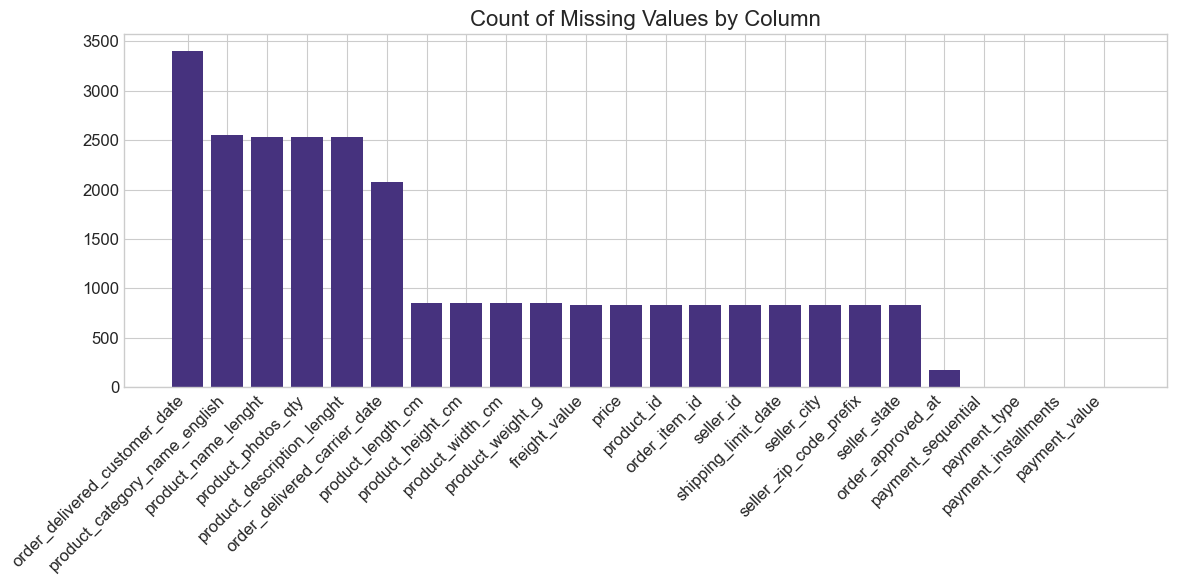

In [20]:
# Visualize missing values
plt.figure(figsize=(12, 6))
plt.bar(missing_values.index, missing_values.values)
plt.title('Count of Missing Values by Column', size=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Handle Missing Values

In [22]:
# Handle missing values
def handle_missing_values(df):
    # Make a copy to avoid modifying the original dataframe
    df_clean = df.copy()
    
    # Handle missing categorical variables
    for col in ['product_category_name_english', 'customer_city', 'seller_city']:
        if col in df_clean.columns and df_clean[col].isnull().sum() > 0:
            # Replace with the most common value
            df_clean[col] = df_clean[col].fillna(df_clean[col].mode()[0])
    
    # Handle missing numerical variables
    for col in ['price', 'freight_value', 'payment_value']:
        if col in df_clean.columns and df_clean[col].isnull().sum() > 0:
            # Replace with median (less sensitive to outliers than mean)
            df_clean[col] = df_clean[col].fillna(df_clean[col].median())
    
    # Handle missing dates with the median date
    date_cols = ['order_purchase_timestamp', 'order_approved_at', 
                'order_delivered_carrier_date', 'order_delivered_customer_date']
    
    for col in date_cols:
        if col in df_clean.columns and df_clean[col].isnull().sum() > 0:
            # Make sure the column is in datetime format
            if not pd.api.types.is_datetime64_dtype(df_clean[col]):
                df_clean[col] = pd.to_datetime(df_clean[col], errors='coerce')
            
            # For datetime columns, we need a different approach for median
            # Using the middle value after sorting is a good approximation
            non_null_dates = df_clean[col].dropna()
            if len(non_null_dates) > 0:
                median_date = non_null_dates.sort_values().iloc[len(non_null_dates) // 2]
                df_clean[col] = df_clean[col].fillna(median_date)
    
    # Drop rows where order_id or customer_id is missing as these are critical
    if 'order_id' in df_clean.columns and df_clean['order_id'].isnull().sum() > 0:
        df_clean = df_clean.dropna(subset=['order_id'])
    
    if 'customer_id' in df_clean.columns and df_clean['customer_id'].isnull().sum() > 0:
        df_clean = df_clean.dropna(subset=['customer_id'])
        
    return df_clean

# Apply missing value handling
df_clean = handle_missing_values(df)

In [23]:
# Verify no critical missing values remain
print("Missing values after handling:")
print(df_clean[['order_id', 'customer_id', 'price', 'freight_value']].isnull().sum())

Missing values after handling:
order_id         0
customer_id      0
price            0
freight_value    0
dtype: int64


# Datetime Values

In [24]:
# Convert datetime strings to datetime
def enrich_temporal_features(df):
    # Ensure order_purchase_date is datetime
    df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
    
    # Create order_purchase_date from timestamp for easier reference
    df['order_purchase_date'] = df['order_purchase_timestamp'].dt.date
    
    # Extract basic time components
    df['year'] = df['order_purchase_timestamp'].dt.year
    df['month'] = df['order_purchase_timestamp'].dt.month
    df['day'] = df['order_purchase_timestamp'].dt.day
    df['hour'] = df['order_purchase_timestamp'].dt.hour
    df['day_of_week'] = df['order_purchase_timestamp'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)  # 5=Sat, 6=Sun
    
    # Time of day categories
    df['time_of_day'] = pd.cut(
        df['hour'], 
        bins=[0, 6, 12, 18, 24], 
        labels=['Night', 'Morning', 'Afternoon', 'Evening'],
        include_lowest=True
    )
    
    # Week of the month (1-5)
    df['week_of_month'] = ((df['day'] - 1) // 7) + 1
    
    # Part of month (beginning, middle, end)
    df['part_of_month'] = pd.cut(
        df['day'], 
        bins=[0, 10, 20, 32], 
        labels=['Beginning', 'Middle', 'End'],
        include_lowest=True
    )
    
    # Quarter of the year
    df['quarter'] = ((df['month'] - 1) // 3) + 1
    
    # Month of the year (name)
    month_names = {
        1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
        7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
    }
    df['month_name'] = df['month'].map(month_names)
    
    # Season (for Brazil, seasons are inverted compared to Northern Hemisphere)
    season_mapping = {
        1: 'Summer', 2: 'Summer', 3: 'Fall', 4: 'Fall', 5: 'Fall',
        6: 'Winter', 7: 'Winter', 8: 'Winter', 9: 'Spring', 10: 'Spring',
        11: 'Spring', 12: 'Summer'
    }
    df['season'] = df['month'].map(season_mapping)
    
    # Brazil holidays (example of major ones)
    holidays = {
        '2016-01-01': 'New Year',
        '2016-02-09': 'Carnival',
        '2016-03-25': 'Good Friday',
        '2016-04-21': 'Tiradentes Day',
        '2016-05-01': 'Labor Day',
        '2016-09-07': 'Independence Day',
        '2016-10-12': 'Our Lady of Aparecida',
        '2016-11-02': 'All Souls Day',
        '2016-11-15': 'Republic Proclamation Day',
        '2016-12-25': 'Christmas',
        '2017-01-01': 'New Year',
        '2017-02-28': 'Carnival',
        '2017-04-14': 'Good Friday',
        '2017-04-21': 'Tiradentes Day',
        '2017-05-01': 'Labor Day',
        '2017-09-07': 'Independence Day',
        '2017-10-12': 'Our Lady of Aparecida',
        '2017-11-02': 'All Souls Day',
        '2017-11-15': 'Republic Proclamation Day',
        '2017-12-25': 'Christmas',
        '2018-01-01': 'New Year',
        '2018-02-13': 'Carnival',
        '2018-03-30': 'Good Friday',
        '2018-04-21': 'Tiradentes Day',
        '2018-05-01': 'Labor Day',
        '2018-09-07': 'Independence Day',
        '2018-10-12': 'Our Lady of Aparecida',
        '2018-11-02': 'All Souls Day',
        '2018-11-15': 'Republic Proclamation Day',
        '2018-12-25': 'Christmas'
    }
    
    # Convert date to string format matching keys in holidays dictionary
    date_str = df['order_purchase_timestamp'].dt.strftime('%Y-%m-%d')
    df['is_holiday'] = date_str.isin(holidays.keys()).astype(int)
    
    # Get the holiday name if it's a holiday
    df['holiday_name'] = date_str.map(holidays)
    
    return df

# Apply enhanced temporal features
df = enrich_temporal_features(df)

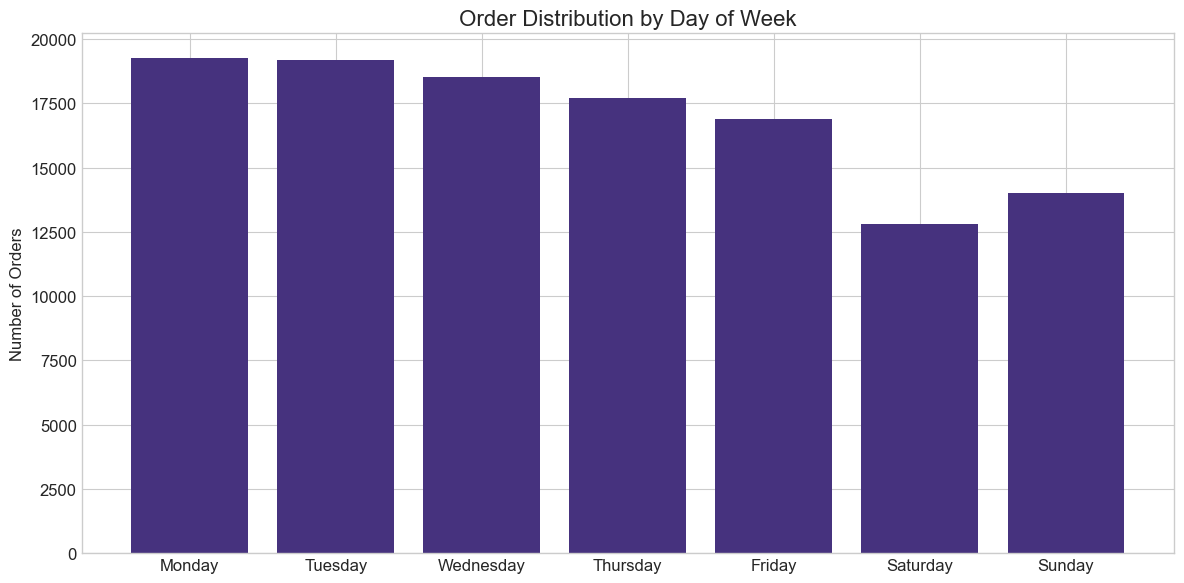

In [26]:
# Visualize day of week distribution
plt.figure(figsize=(12, 6))
order_dow = df.groupby('day_of_week').size()
plt.bar(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
    order_dow.values
)
plt.title('Order Distribution by Day of Week', size=16)
plt.ylabel('Number of Orders')
plt.tight_layout()
plt.show()

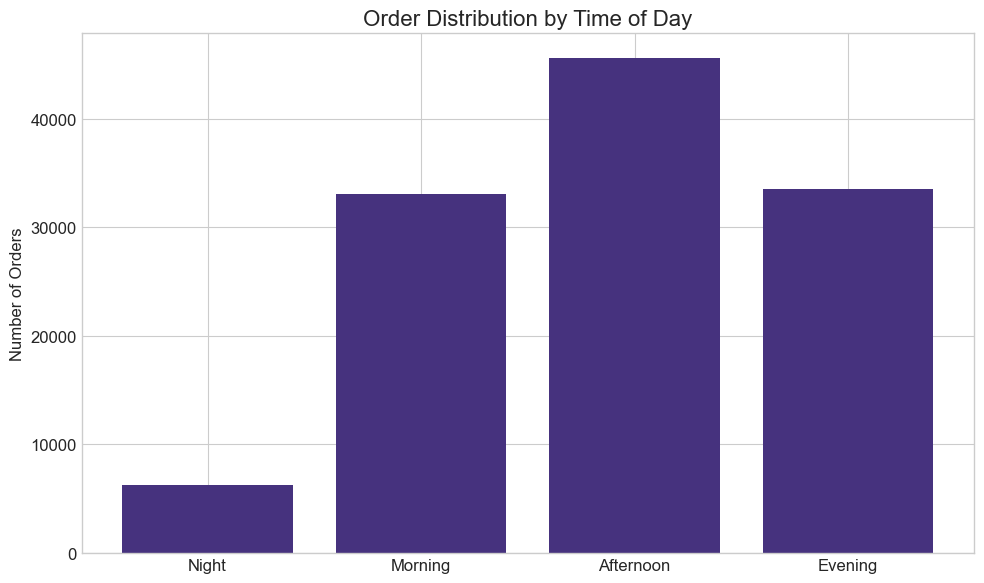

In [27]:
# Visualize time of day distribution
plt.figure(figsize=(10, 6))
order_tod = df.groupby('time_of_day').size()
plt.bar(order_tod.index, order_tod.values)
plt.title('Order Distribution by Time of Day', size=16)
plt.ylabel('Number of Orders')
plt.tight_layout()
plt.show()

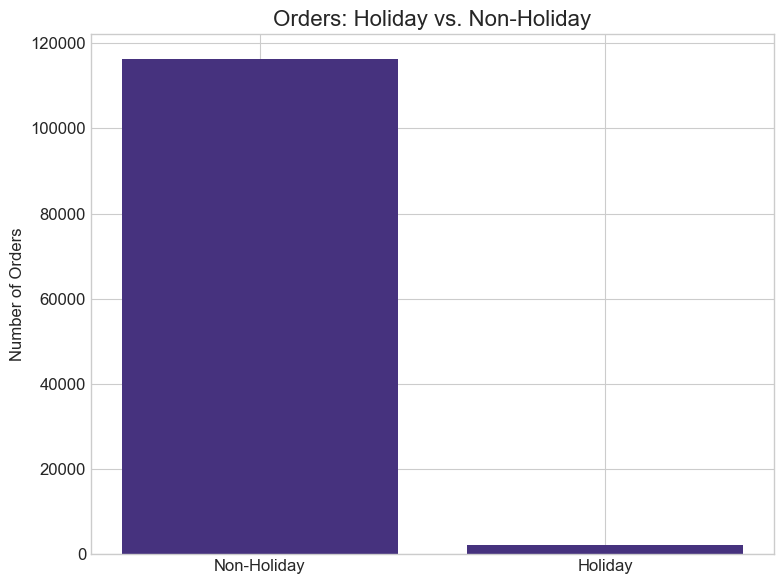

In [28]:
# Orders by holiday vs non-holiday
plt.figure(figsize=(8, 6))
holiday_orders = df.groupby('is_holiday').size()
plt.bar(['Non-Holiday', 'Holiday'], holiday_orders.values)
plt.title('Orders: Holiday vs. Non-Holiday', size=16)
plt.ylabel('Number of Orders')
plt.tight_layout()
plt.show()

# Separation between Numerical and Categorical Features

In [29]:
# Numerical features
num_features = df.select_dtypes(exclude=[np.object_, pd.CategoricalDtype]).columns
df[num_features].describe()

# Categorical features
cat_features = df.select_dtypes(include=[np.object_, pd.CategoricalDtype]).columns
df[cat_features].describe()

,order_id,customer_id,order_status,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_id,seller_id,shipping_limit_date,...,customer_unique_id,customer_city,customer_state,payment_type,order_purchase_date,time_of_day,part_of_month,month_name,season,holiday_name
count,118434,118434,118434,118258,116360,115037,118434,117604,117604,117604,...,118434,118434,118434,118431,118434,118434,118434,118434,118434,2144
unique,99441,99441,8,90733,81018,95664,459,32951,3095,93318,...,96096,4119,27,5,634,4,3,12,4,10
top,895ab968e7bb0d5659d16cd74cd1650c,270c23a11d024a44c896d1894b261a83,delivered,2017-08-08 20:43:31,2017-08-10 11:58:14,2017-08-14 12:46:18,2017-12-20 00:00:00,aca2eb7d00ea1a7b8ebd4e68314663af,4a3ca9315b744ce9f8e9374361493884,2017-08-14 20:43:31,...,9a736b248f67d166d2fbb006bcb877c3,sao paulo,SP,credit_card,2017-11-24,Afternoon,Middle,Aug,Winter,Labor Day
freq,63,63,115038,63,63,63,656,536,2133,63,...,75,18738,49967,87286,1420,45581,39913,12745,36207,439


# Create RFM (Recency, Frequency, Monetary) features for customer segmentation

In [32]:
def create_rfm_features(df):
    # Make sure we have a datetime column for the purchase date
    if not pd.api.types.is_datetime64_dtype(df['order_purchase_timestamp']):
        df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
    
    # Get the most recent date in the dataset
    max_date = df['order_purchase_timestamp'].max()
    
    # Group by customer_id to create customer-level features
    customer_features = df.groupby('customer_unique_id').agg({
        'order_purchase_timestamp': [
            lambda x: (max_date - x.max()).days,  # Recency
            lambda x: (x.max() - x.min()).days if len(x) > 1 else 0  # Customer lifetime (days)
        ],
        'order_id': ['nunique'],  # Frequency
        'payment_value': ['sum'],  # Monetary (total spent)
        'price': ['mean', 'sum'],  # Average and total order value
        'freight_value': ['sum'],  # Total shipping cost
        'product_category_name_english': [lambda x: x.nunique()],  # Product category diversity
        'seller_id': [lambda x: x.nunique()],  # Number of unique sellers
        'payment_installments': ['mean'],  # Average installments
        'payment_type': [lambda x: x.mode()[0] if len(x.mode()) > 0 else None]  # Preferred payment type
    })
    
    # Flatten the MultiIndex columns and rename them properly
    customer_features.columns = ['_'.join(col).strip('_') for col in customer_features.columns.values]
    
    # Explicitly rename columns to avoid reference issues
    column_map = {
        'order_purchase_timestamp_<lambda_0>': 'recency_days',
        'order_purchase_timestamp_<lambda_1>': 'customer_lifetime_days',
        'order_id_nunique': 'frequency',
        'payment_value_sum': 'monetary_total',
        'price_mean': 'avg_order_value',
        'price_sum': 'total_spent_products',
        'freight_value_sum': 'total_shipping_cost',
        'product_category_name_english_<lambda>': 'category_diversity',
        'seller_id_<lambda>': 'unique_sellers',
        'payment_installments_mean': 'avg_installments',
        'payment_type_<lambda>': 'preferred_payment'
    }
    
    # Rename the columns, handling any variations in naming
    for old_col, new_col in column_map.items():
        for col in customer_features.columns:
            if old_col in col:  # Using "in" to handle slight variations in the lambda names
                customer_features.rename(columns={col: new_col}, inplace=True)
    
    # Add the average time between orders (in days)
    # First, get all purchase dates for each customer
    purchase_dates = df.groupby(['customer_unique_id', 'order_id'])['order_purchase_timestamp'].max().reset_index()
    
    # Sort by customer and date
    purchase_dates = purchase_dates.sort_values(['customer_unique_id', 'order_purchase_timestamp'])
    
    # Calculate time difference between consecutive purchases for each customer
    time_diffs = []
    for customer, group in purchase_dates.groupby('customer_unique_id'):
        if len(group) > 1:
            # Calculate differences between consecutive dates
            diffs = [(group['order_purchase_timestamp'].iloc[i] - group['order_purchase_timestamp'].iloc[i-1]).days 
                     for i in range(1, len(group))]
            time_diffs.append((customer, np.mean(diffs) if diffs else 0))
        else:
            time_diffs.append((customer, 0))
    
    # Convert to DataFrame and merge with customer features
    time_diff_df = pd.DataFrame(time_diffs, columns=['customer_unique_id', 'avg_days_between_orders'])
    
    # Reset index to make customer_unique_id a column
    customer_features = customer_features.reset_index()
    
    # Merge with time differences
    customer_features = customer_features.merge(time_diff_df, on='customer_unique_id', how='left')
    
    # Add average order value to shipping ratio
    customer_features['avg_product_to_shipping_ratio'] = (
        customer_features['total_spent_products'] / 
        customer_features['total_shipping_cost'].replace(0, 1)  # Prevent division by zero
    )
    
    # Calculate purchase frequency (orders per month of activity)
    # Add 1 to customer_lifetime_days to prevent division by zero
    customer_features['purchase_frequency_monthly'] = (
        customer_features['frequency'] / 
        ((customer_features['customer_lifetime_days'] + 1) / 30)
    )
    
    # Add monetary per frequency (spending per order)
    customer_features['monetary_per_order'] = (
        customer_features['monetary_total'] / 
        customer_features['frequency'].replace(0, 1)  # Prevent division by zero
    )
    
    return customer_features

In [33]:
# Create customer-centric features
customer_rfm = create_rfm_features(df)

# Display basic statistics about the customer features
print(customer_rfm.describe())

       recency_days  customer_lifetime_days     frequency  monetary_total  \
count  96096.000000            96096.000000  96096.000000    96096.000000   
mean     287.735691                2.711507      1.034809      213.023712   
std      153.414676               25.393343      0.214384      640.917083   
min        0.000000                0.000000      1.000000        0.000000   
25%      163.000000                0.000000      1.000000       63.990000   
50%      268.000000                0.000000      1.000000      113.150000   
75%      397.000000                0.000000      1.000000      202.732500   
max      772.000000              633.000000     17.000000   109312.640000   

       avg_order_value  total_spent_products  total_shipping_cost  \
count     95420.000000          96096.000000         96096.000000   
mean        126.519110            147.865159            24.532103   
std         191.746417            248.020347            27.736439   
min           0.850000        

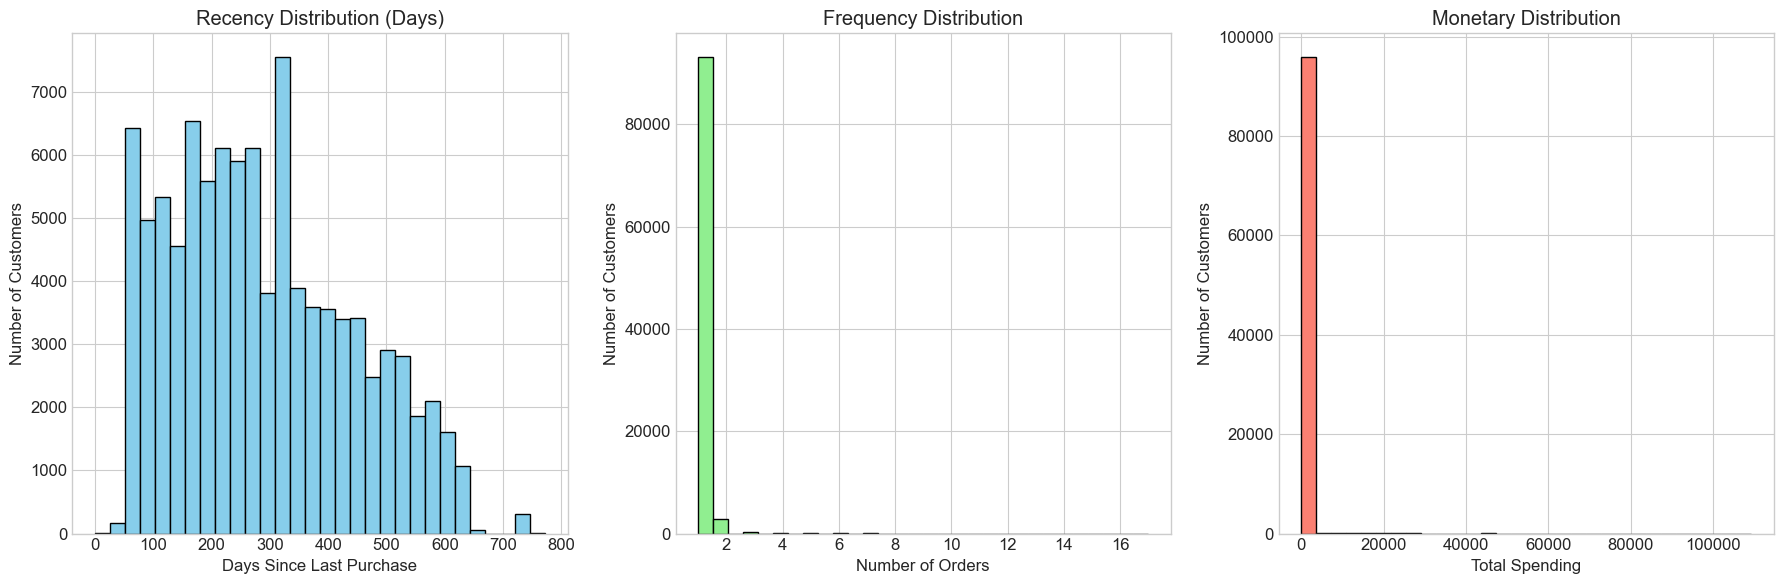

In [34]:
# Visualize RFM distributions
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.hist(customer_rfm['recency_days'], bins=30, color='skyblue', edgecolor='black')
plt.title('Recency Distribution (Days)')
plt.xlabel('Days Since Last Purchase')
plt.ylabel('Number of Customers')

plt.subplot(1, 3, 2)
plt.hist(customer_rfm['frequency'], bins=30, color='lightgreen', edgecolor='black')
plt.title('Frequency Distribution')
plt.xlabel('Number of Orders')
plt.ylabel('Number of Customers')

plt.subplot(1, 3, 3)
plt.hist(customer_rfm['monetary_total'], bins=30, color='salmon', edgecolor='black')
plt.title('Monetary Distribution')
plt.xlabel('Total Spending')
plt.ylabel('Number of Customers')

plt.tight_layout()
plt.show()

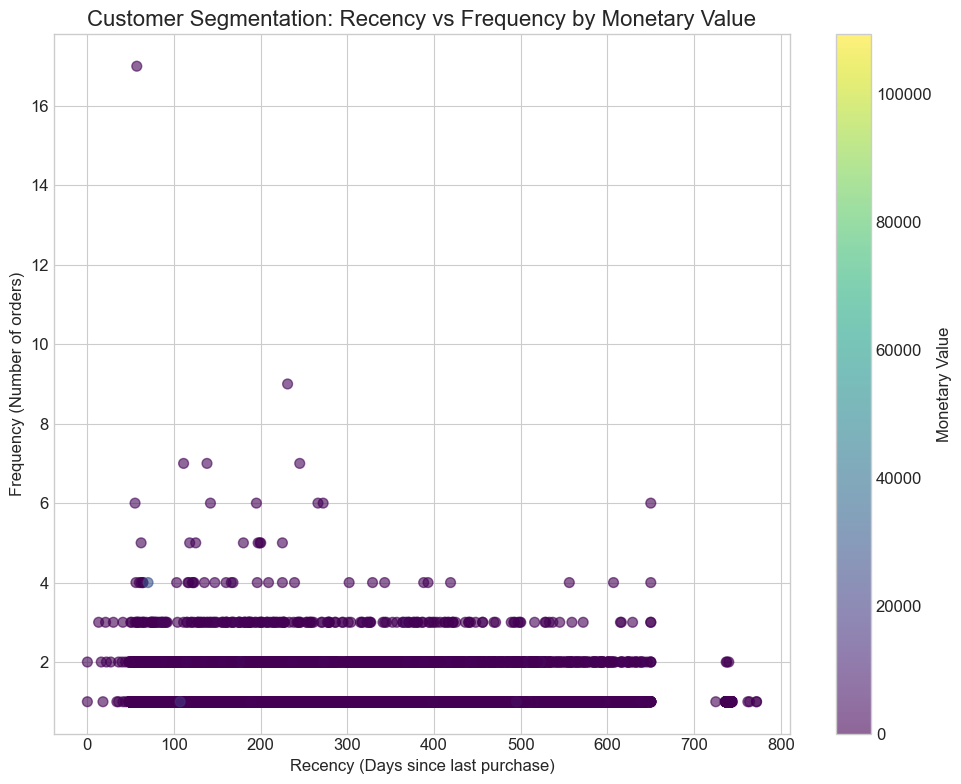

In [35]:
# Scatter plot of Recency vs Frequency colored by Monetary value
plt.figure(figsize=(10, 8))
plt.scatter(
    customer_rfm['recency_days'], 
    customer_rfm['frequency'],
    c=customer_rfm['monetary_total'], 
    cmap='viridis',
    alpha=0.6,
    s=50
)
plt.colorbar(label='Monetary Value')
plt.title('Customer Segmentation: Recency vs Frequency by Monetary Value', size=16)
plt.xlabel('Recency (Days since last purchase)')
plt.ylabel('Frequency (Number of orders)')
plt.tight_layout()
plt.show()

# Statistical analysis of key metrics

In [36]:
def perform_statistical_analysis(df, customer_df):
    # Order-level statistics
    order_stats = {
        'Order Value': df['price'].describe(),
        'Shipping Cost': df['freight_value'].describe(),
        'Payment Value': df['payment_value'].describe(),
        'Payment Installments': df['payment_installments'].describe()
    }
    
    # Print order-level statistics
    print("ORDER-LEVEL STATISTICS:")
    for metric, stats in order_stats.items():
        print(f"\n{metric}:")
        print(stats)
    
    # Customer-level statistics
    customer_stats = {
        'Recency (days)': customer_df['recency_days'].describe(),
        'Frequency (orders)': customer_df['frequency'].describe(),
        'Monetary (total)': customer_df['monetary_total'].describe(),
        'Average Order Value': customer_df['avg_order_value'].describe(),
        'Product Category Diversity': customer_df['category_diversity'].describe(),
        'Purchase Frequency Monthly': customer_df['purchase_frequency_monthly'].describe()
    }
    
    # Print customer-level statistics
    print("\n\nCUSTOMER-LEVEL STATISTICS:")
    for metric, stats in customer_stats.items():
        print(f"\n{metric}:")
        print(stats)
    
    # Calculate statistical significance between high and low value customers
    print("\n\nSTATISTICAL COMPARISON OF HIGH VS LOW VALUE CUSTOMERS:")
    
    # Split customers into high value (top 20%) and low value (bottom 20%) based on monetary value
    high_value_threshold = customer_df['monetary_total'].quantile(0.8)
    low_value_threshold = customer_df['monetary_total'].quantile(0.2)
    
    high_value_customers = customer_df[customer_df['monetary_total'] >= high_value_threshold]
    low_value_customers = customer_df[customer_df['monetary_total'] <= low_value_threshold]
    
    # Compare metrics
    comparison_metrics = [
        'recency_days', 'frequency', 'avg_order_value', 
        'category_diversity', 'avg_installments', 'purchase_frequency_monthly'
    ]
    
    for metric in comparison_metrics:
        high_values = high_value_customers[metric]
        low_values = low_value_customers[metric]
        
        print(f"\nMetric: {metric}")
        print(f"High Value Customers (n={len(high_values)}):")
        print(f"  Mean: {high_values.mean():.2f}")
        print(f"  Median: {high_values.median():.2f}")
        print(f"Low Value Customers (n={len(low_values)}):")
        print(f"  Mean: {low_values.mean():.2f}")
        print(f"  Median: {low_values.median():.2f}")
        
        # Calculate effect size (Cohen's d)
        pooled_std = np.sqrt((high_values.std()**2 + low_values.std()**2) / 2)
        effect_size = (high_values.mean() - low_values.mean()) / pooled_std
        print(f"  Effect Size (Cohen's d): {effect_size:.2f}")
        
        # Interpretation of effect size
        if abs(effect_size) < 0.2:
            effect = "negligible"
        elif abs(effect_size) < 0.5:
            effect = "small"
        elif abs(effect_size) < 0.8:
            effect = "medium"
        else:
            effect = "large"
        
        print(f"  Interpretation: {effect.capitalize()} effect")
    
    return order_stats, customer_stats

In [37]:
# Perform statistical analysis
order_stats, customer_stats = perform_statistical_analysis(df, customer_rfm)

ORDER-LEVEL STATISTICS:

Order Value:
count    117604.000000
mean        120.822849
std         184.477367
min           0.850000
25%          39.900000
50%          74.900000
75%         134.900000
max        6735.000000
Name: price, dtype: float64

Shipping Cost:
count    117604.000000
mean         20.045551
std          15.861351
min           0.000000
25%          13.080000
50%          16.290000
75%          21.190000
max         409.680000
Name: freight_value, dtype: float64

Payment Value:
count    118431.000000
mean        172.849395
std         268.259831
min           0.000000
25%          60.860000
50%         108.200000
75%         189.245000
max       13664.080000
Name: payment_value, dtype: float64

Payment Installments:
count    118431.000000
mean          2.937398
std           2.774164
min           0.000000
25%           1.000000
50%           2.000000
75%           4.000000
max          24.000000
Name: payment_installments, dtype: float64


CUSTOMER-LEVEL STATISTICS:

# Analyze customer behavior patterns

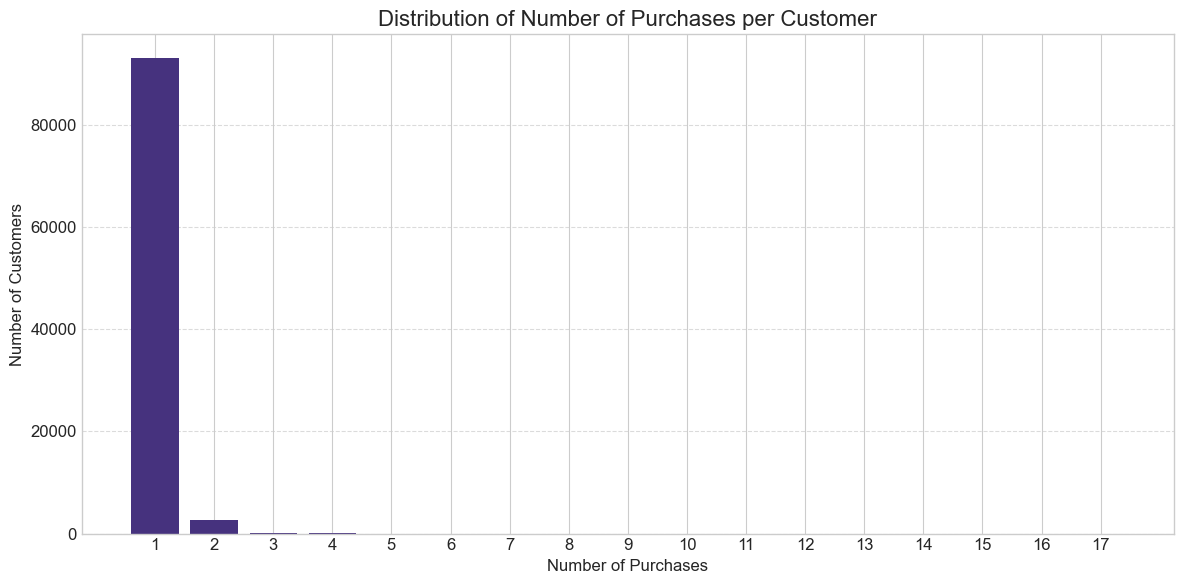

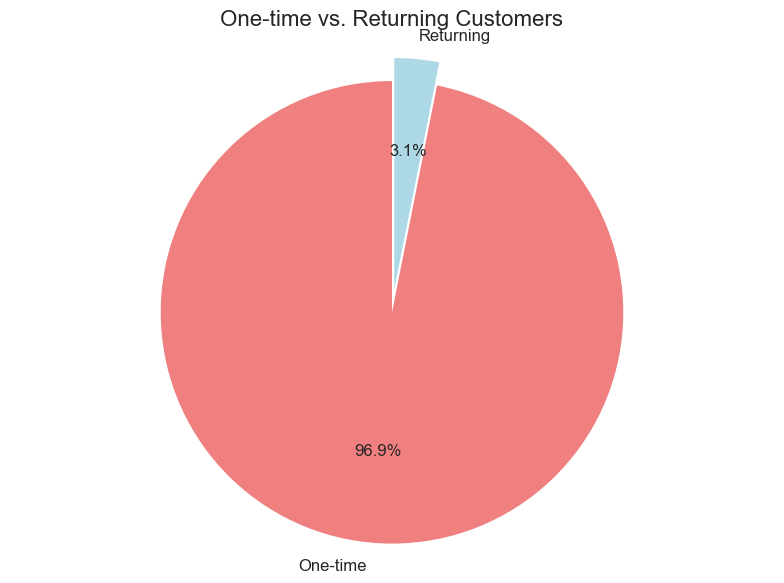

One-time customers: 93099 (96.9%)
Returning customers: 2997 (3.1%)


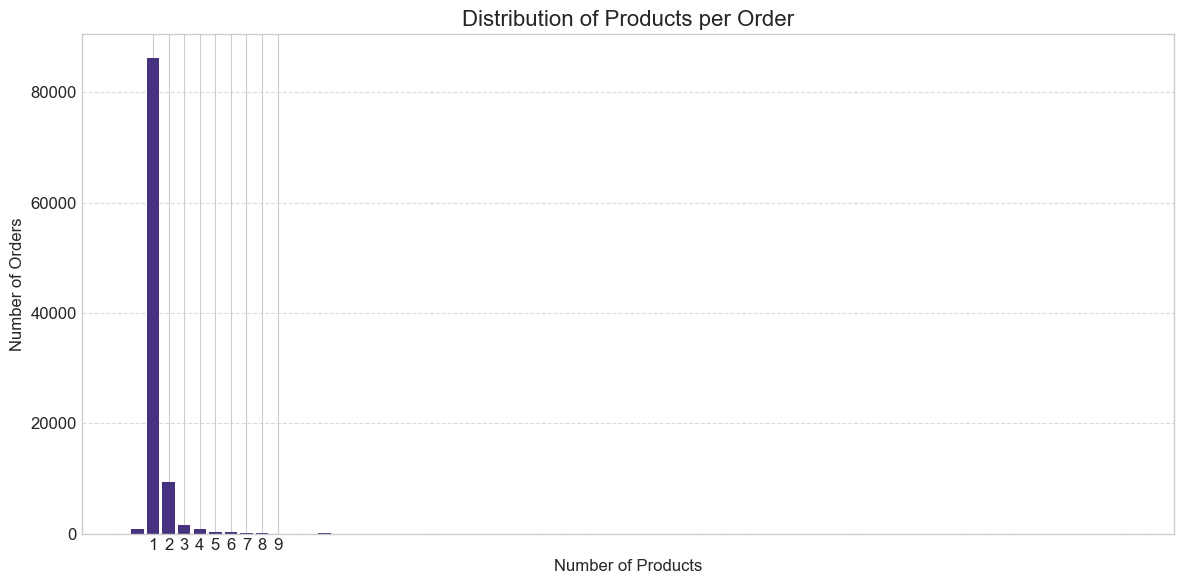

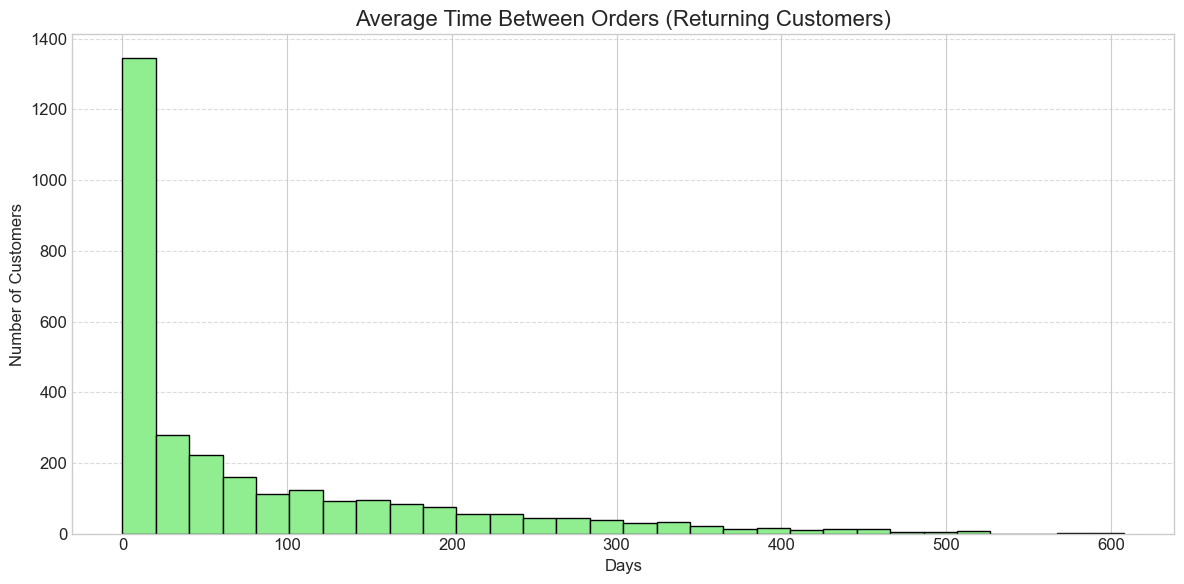

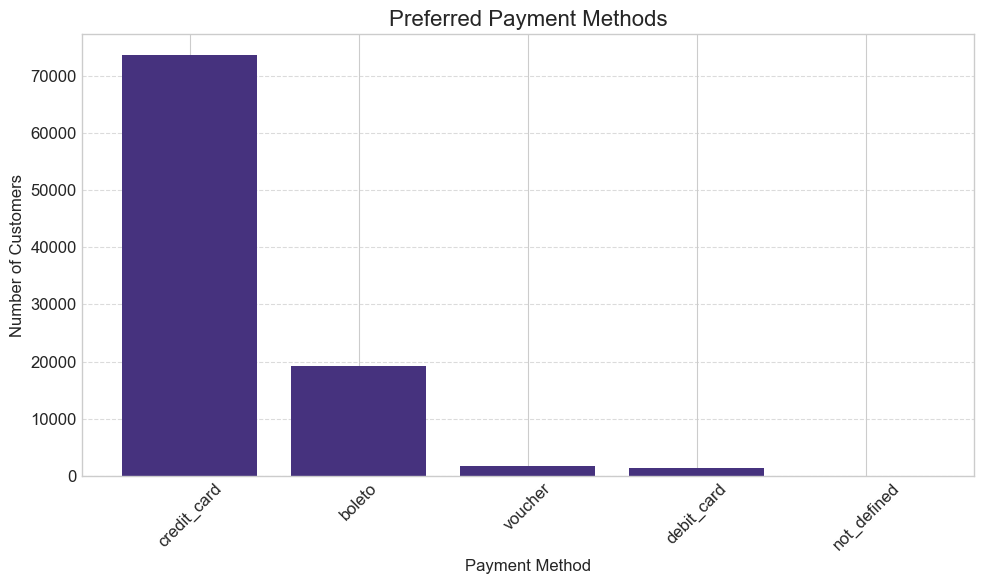

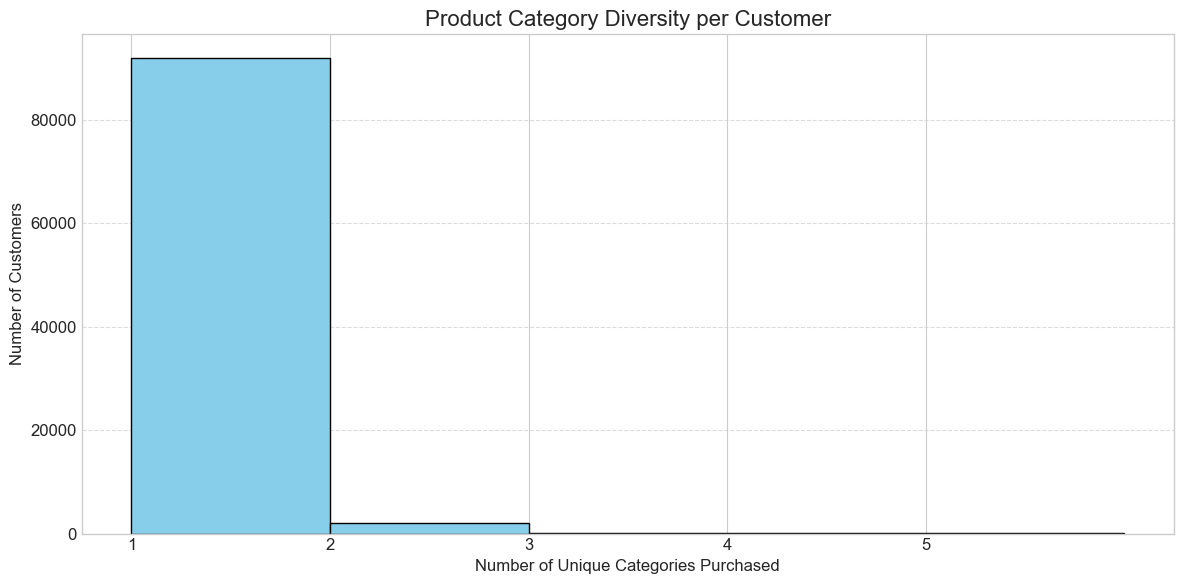

In [38]:
def analyze_customer_behavior(df, customer_df):
    # 1. Purchase frequency patterns
    plt.figure(figsize=(12, 6))
    purchase_counts = customer_df['frequency'].value_counts().sort_index()
    plt.bar(purchase_counts.index, purchase_counts.values)
    plt.title('Distribution of Number of Purchases per Customer', size=16)
    plt.xlabel('Number of Purchases')
    plt.ylabel('Number of Customers')
    plt.xticks(range(1, purchase_counts.index.max() + 1))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # 2. One-time vs returning customers
    one_time = (customer_df['frequency'] == 1).sum()
    returning = (customer_df['frequency'] > 1).sum()
    
    plt.figure(figsize=(8, 6))
    plt.pie(
        [one_time, returning],
        labels=['One-time', 'Returning'],
        autopct='%1.1f%%',
        colors=['lightcoral', 'lightblue'],
        startangle=90,
        explode=(0.1, 0)
    )
    plt.title('One-time vs. Returning Customers', size=16)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()
    
    print(f"One-time customers: {one_time} ({one_time/(one_time+returning)*100:.1f}%)")
    print(f"Returning customers: {returning} ({returning/(one_time+returning)*100:.1f}%)")
    
    # 3. Products per order distribution
    orders_with_products = df.groupby('order_id')['product_id'].count().reset_index()
    orders_with_products.columns = ['order_id', 'products_count']
    
    plt.figure(figsize=(12, 6))
    products_per_order = orders_with_products['products_count'].value_counts().sort_index()
    plt.bar(products_per_order.index, products_per_order.values)
    plt.title('Distribution of Products per Order', size=16)
    plt.xlabel('Number of Products')
    plt.ylabel('Number of Orders')
    plt.xticks(range(1, min(10, products_per_order.index.max() + 1)))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # 4. Time between purchases for returning customers
    time_between_orders = customer_df[customer_df['frequency'] > 1]['avg_days_between_orders']
    
    plt.figure(figsize=(12, 6))
    plt.hist(time_between_orders, bins=30, color='lightgreen', edgecolor='black')
    plt.title('Average Time Between Orders (Returning Customers)', size=16)
    plt.xlabel('Days')
    plt.ylabel('Number of Customers')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # 5. Customer distribution by payment method
    payment_methods = customer_df['preferred_payment'].value_counts()
    
    plt.figure(figsize=(10, 6))
    plt.bar(payment_methods.index, payment_methods.values)
    plt.title('Preferred Payment Methods', size=16)
    plt.xlabel('Payment Method')
    plt.ylabel('Number of Customers')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # 6. Product category diversity
    plt.figure(figsize=(12, 6))
    plt.hist(customer_df['category_diversity'], bins=range(1, customer_df['category_diversity'].max() + 2), 
             color='skyblue', edgecolor='black')
    plt.title('Product Category Diversity per Customer', size=16)
    plt.xlabel('Number of Unique Categories Purchased')
    plt.ylabel('Number of Customers')
    plt.xticks(range(1, customer_df['category_diversity'].max() + 1))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    return {
        'one_time_customers': one_time,
        'returning_customers': returning,
        'avg_time_between_orders': time_between_orders.mean(),
        'avg_products_per_order': orders_with_products['products_count'].mean()
    }

# Analyze customer behavior
behavior_metrics = analyze_customer_behavior(df, customer_rfm)

# Data transformation for skewed features

In [42]:
def transform_skewed_features(df, customer_df):
    # Identify numerical features in the order dataframe
    order_numeric_features = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    
    # Identify numerical features in the customer dataframe
    customer_numeric_features = customer_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    
    # Calculate skewness for order features
    order_skewness = pd.DataFrame({
        'Feature': order_numeric_features,
        'Skewness': [df[col].skew() for col in order_numeric_features]
    }).sort_values('Skewness', ascending=False)
    
    # Calculate skewness for customer features
    customer_skewness = pd.DataFrame({
        'Feature': customer_numeric_features,
        'Skewness': [customer_df[col].skew() for col in customer_numeric_features]
    }).sort_values('Skewness', ascending=False)
    
    print("Order features with highest skewness:")
    print(order_skewness.head(10))
    
    print("\nCustomer features with highest skewness:")
    print(customer_skewness.head(10))
    
    # Identify highly skewed features (|skewness| > 1)
    highly_skewed_order = order_skewness[abs(order_skewness['Skewness']) > 1]['Feature'].tolist()
    highly_skewed_customer = customer_skewness[abs(customer_skewness['Skewness']) > 1]['Feature'].tolist()
    
    # Apply log transformation to highly skewed features
    df_transformed = df.copy()
    customer_df_transformed = customer_df.copy()
    
    # Track which features were successfully transformed
    transformed_order_features = []
    transformed_customer_features = []
    
    for col in highly_skewed_order:
        # Only transform positive columns (log transformation requires positive values)
        if (df[col] > 0).all():
            transformed_col = f'{col}_log'
            df_transformed[transformed_col] = np.log1p(df[col])  # log1p = log(1+x) to handle zeros
            transformed_order_features.append((col, transformed_col))
    
    for col in highly_skewed_customer:
        # Only transform positive columns
        if (customer_df[col] > 0).all():
            transformed_col = f'{col}_log'
            customer_df_transformed[transformed_col] = np.log1p(customer_df[col])
            transformed_customer_features.append((col, transformed_col))
    
    # Visualize before/after transformation for top 3 skewed features in each dataframe
    if transformed_order_features:
        top_transformed_order = transformed_order_features[:min(3, len(transformed_order_features))]
        fig, axes = plt.subplots(len(top_transformed_order), 2, figsize=(14, 4 * len(top_transformed_order)))
        
        if len(top_transformed_order) == 1:
            axes = np.array([axes])  # Make it 2D for consistent indexing
        
        for i, (original_feature, transformed_feature) in enumerate(top_transformed_order):
            # Original distribution
            sns.histplot(df[original_feature], ax=axes[i, 0], kde=True)
            axes[i, 0].set_title(f'Original: {original_feature} (Skewness: {df[original_feature].skew():.2f})')
            
            # Transformed distribution
            sns.histplot(df_transformed[transformed_feature], ax=axes[i, 1], kde=True)
            axes[i, 1].set_title(f'Log-transformed: {transformed_feature} (Skewness: {df_transformed[transformed_feature].skew():.2f})')
        
        plt.tight_layout()
        plt.show()
    else:
        print("No order features were transformed (no suitable candidates found).")
    
    if transformed_customer_features:
        top_transformed_customer = transformed_customer_features[:min(3, len(transformed_customer_features))]
        fig, axes = plt.subplots(len(top_transformed_customer), 2, figsize=(14, 4 * len(top_transformed_customer)))
        
        if len(top_transformed_customer) == 1:
            axes = np.array([axes])  # Make it 2D for consistent indexing
        
        for i, (original_feature, transformed_feature) in enumerate(top_transformed_customer):
            # Original distribution
            sns.histplot(customer_df[original_feature], ax=axes[i, 0], kde=True)
            axes[i, 0].set_title(f'Original: {original_feature} (Skewness: {customer_df[original_feature].skew():.2f})')
            
            # Transformed distribution
            sns.histplot(customer_df_transformed[transformed_feature], ax=axes[i, 1], kde=True)
            axes[i, 1].set_title(f'Log-transformed: {transformed_feature} (Skewness: {customer_df_transformed[transformed_feature].skew():.2f})')
        
        plt.tight_layout()
        plt.show()
    else:
        print("No customer features were transformed (no suitable candidates found).")
    
    return df_transformed, customer_df_transformed

Order features with highest skewness:
                       Feature   Skewness
12          payment_sequential  15.881705
14               payment_value  13.969151
1                        price   7.885799
0                order_item_id   7.571046
16                  is_holiday   7.229073
2                freight_value   5.542943
6             product_weight_g   3.581241
8            product_height_cm   2.237678
4   product_description_lenght   2.010093
5           product_photos_qty   1.905791

Customer features with highest skewness:
                          Feature   Skewness
13             monetary_per_order  74.923385
3                  monetary_total  69.006035
6             total_shipping_cost  15.975039
11  avg_product_to_shipping_ratio  12.713543
10        avg_days_between_orders  12.605522
1          customer_lifetime_days  12.177252
5            total_spent_products  12.102588
2                       frequency  11.862593
4                 avg_order_value   7.725550
8       

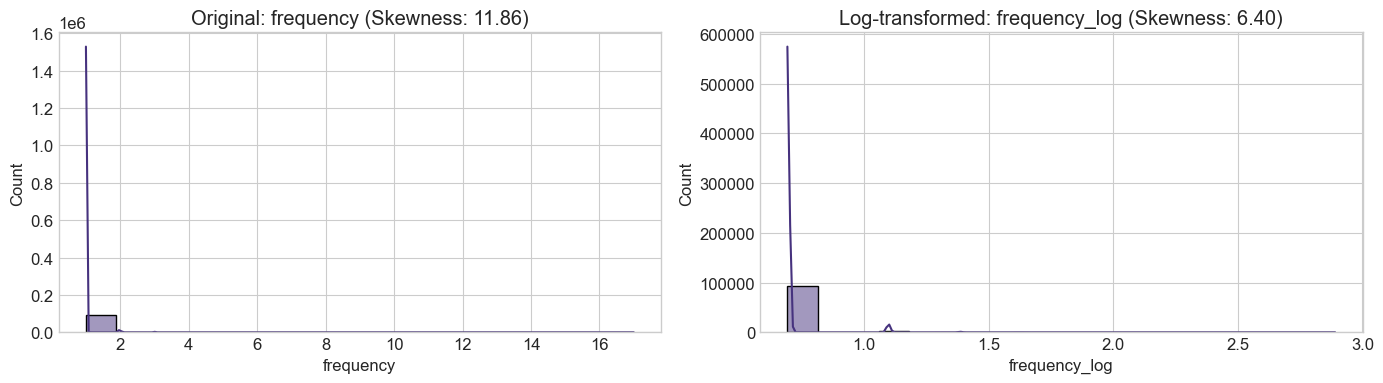

In [43]:
# Transform skewed features
df_transformed, customer_rfm_transformed = transform_skewed_features(df, customer_rfm)

# Analyze correlations with potential segmentation targets

In [44]:
def analyze_correlations(customer_df):
   # Define potential target variables for segmentation
   target_variables = [
       'monetary_total',  # High vs. low value customers
       'frequency',       # Frequent vs. occasional shoppers
       'recency_days',    # Recent vs. inactive customers
       'avg_order_value'  # Big-ticket vs. small-ticket purchasers
   ]
   
   # Select numeric features
   numeric_cols = customer_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
   
   # Calculate correlation matrix
   correlation_matrix = customer_df[numeric_cols].corr()
   
   # Create a DataFrame with correlations to target variables
   target_correlations = {target: correlation_matrix[target].abs().sort_values(ascending=False) 
                         for target in target_variables}
   
   # Plot correlation heatmap for each target
   for target in target_variables:
       # Get top 10 correlations (excluding self-correlation)
       top_correlations = target_correlations[target].drop(target).head(10)
       
       plt.figure(figsize=(10, 6))
       sns.barplot(x=top_correlations.values, y=top_correlations.index)
       plt.title(f'Top 10 Features Correlated with {target}', size=16)
       plt.xlabel('Absolute Correlation')
       plt.xlim(0, 1)
       plt.grid(axis='x', linestyle='--', alpha=0.7)
       plt.tight_layout()
       plt.show()
   
   # Create a combined correlation heatmap for all target variables
   plt.figure(figsize=(12, 10))
   subset_corr = correlation_matrix.loc[target_variables, numeric_cols]
   mask = np.zeros_like(subset_corr, dtype=bool)
   mask[np.triu_indices_from(mask, k=1)] = True  # Mask upper triangle
   
   sns.heatmap(
       subset_corr, 
       mask=mask,
       annot=True, 
       cmap='coolwarm', 
       vmin=-1, 
       vmax=1, 
       fmt='.2f',
       linewidths=0.5,
       cbar_kws={"shrink": .8}
   )
   plt.title('Correlation Between Target Variables and Features', size=16)
   plt.tight_layout()
   plt.show()
   
   # Find multicollinearity among features
   plt.figure(figsize=(16, 14))
   
   # Select a smaller subset of important features to avoid cluttered heatmap
   important_features = []
   for target in target_variables:
       important_features.extend(target_correlations[target].drop(target).head(5).index.tolist())
   
   # Remove duplicates and keep unique features
   important_features = list(set(important_features))
   
   # Add target variables as well
   important_features = target_variables + [f for f in important_features if f not in target_variables]
   
   # Create correlation heatmap for important features
   feature_corr = correlation_matrix.loc[important_features, important_features]
   
   sns.heatmap(
       feature_corr, 
       annot=True, 
       cmap='coolwarm', 
       vmin=-1, 
       vmax=1, 
       fmt='.2f',
       linewidths=0.5,
       cbar_kws={"shrink": .8}
   )
   plt.title('Correlation Among Important Features', size=16)
   plt.tight_layout()
   plt.show()
   
   return target_correlations, correlation_matrix

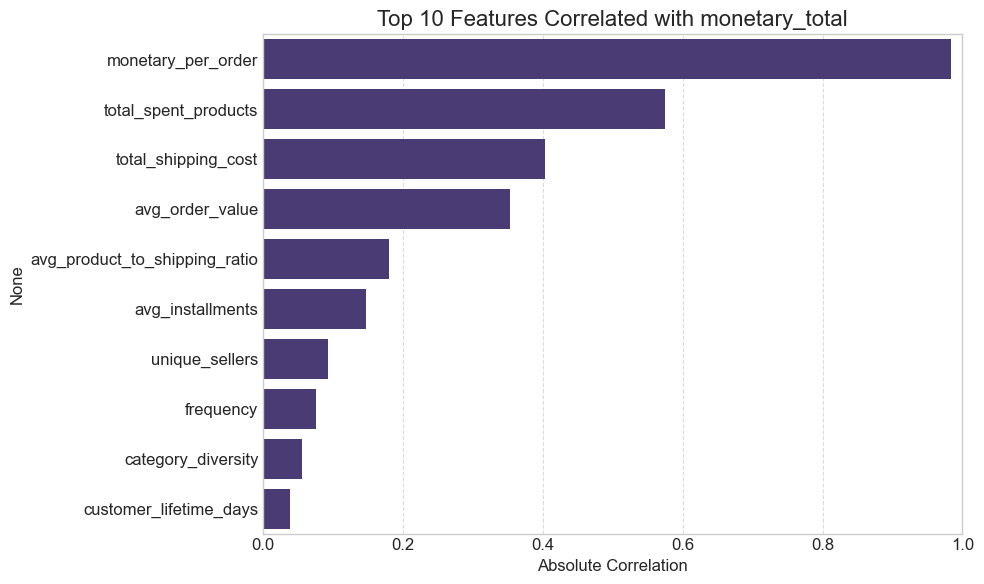

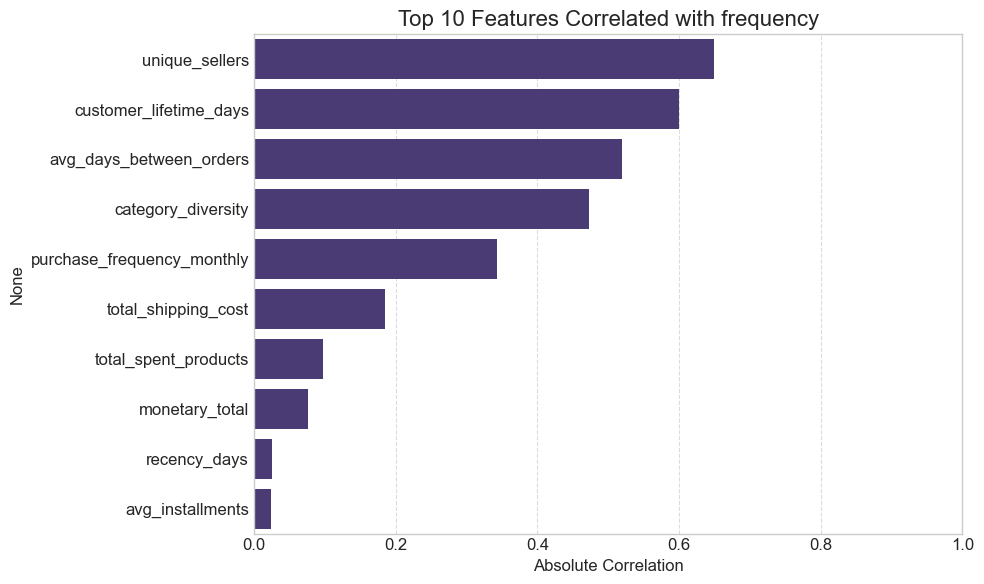

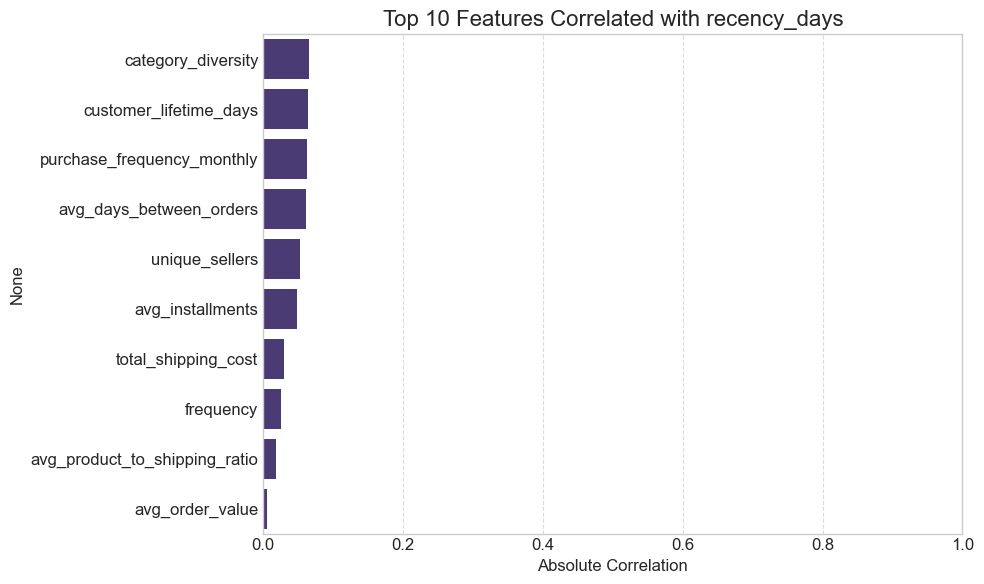

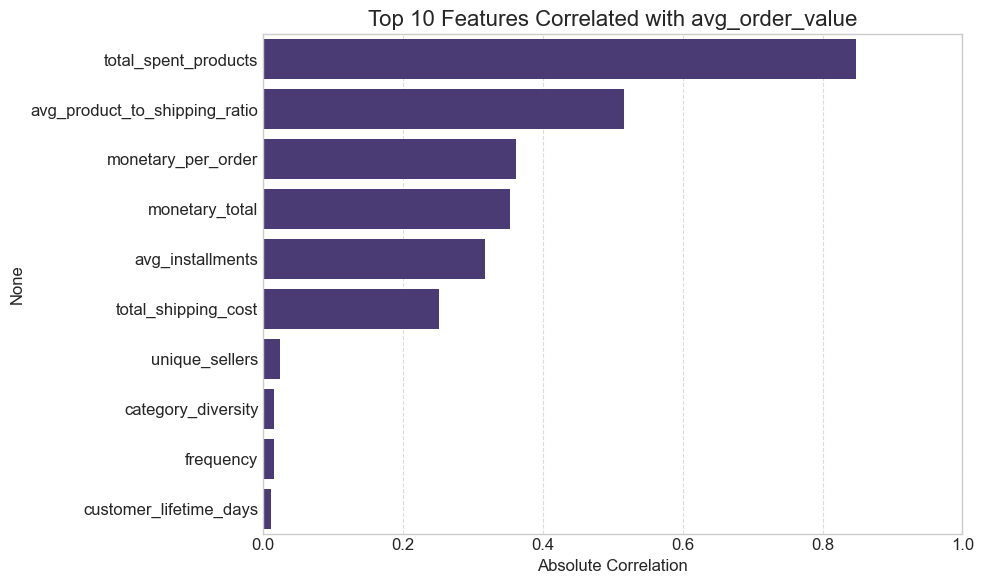

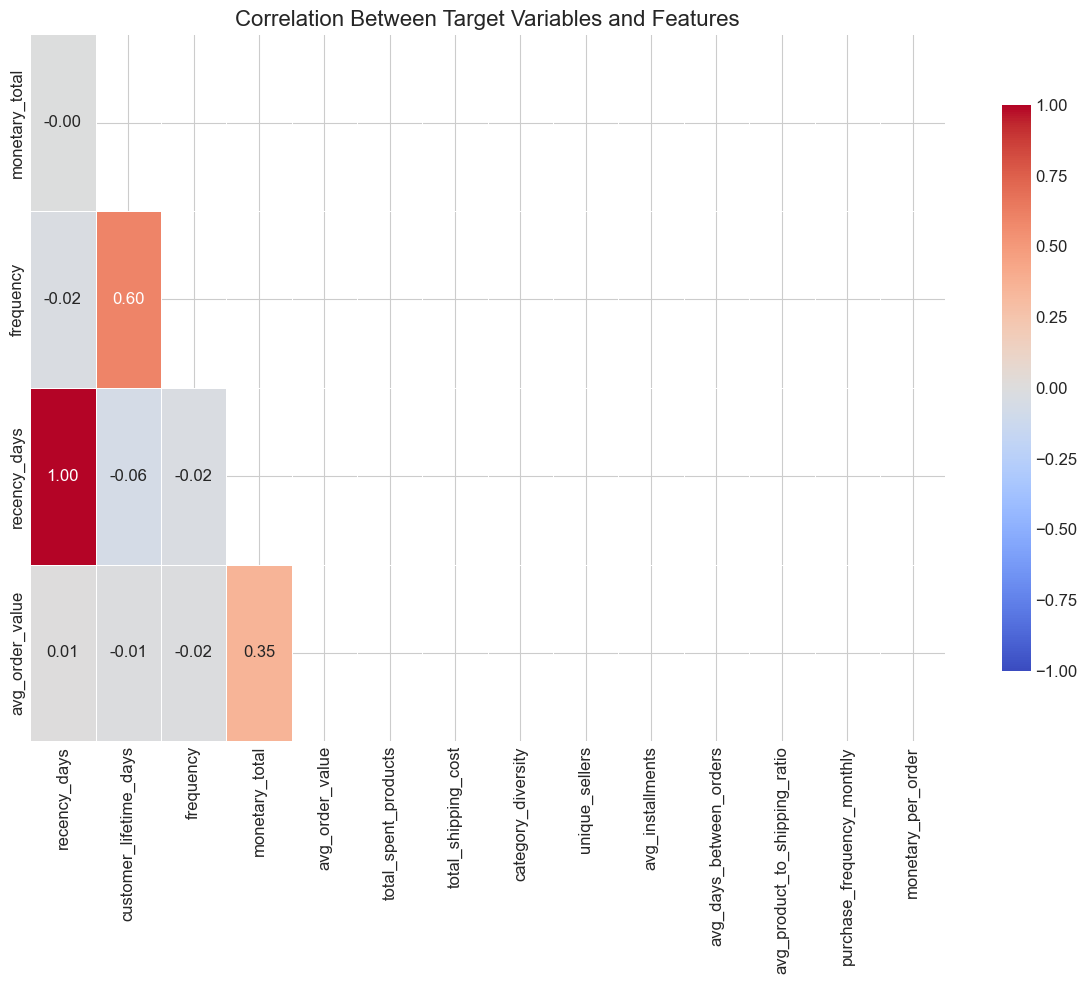

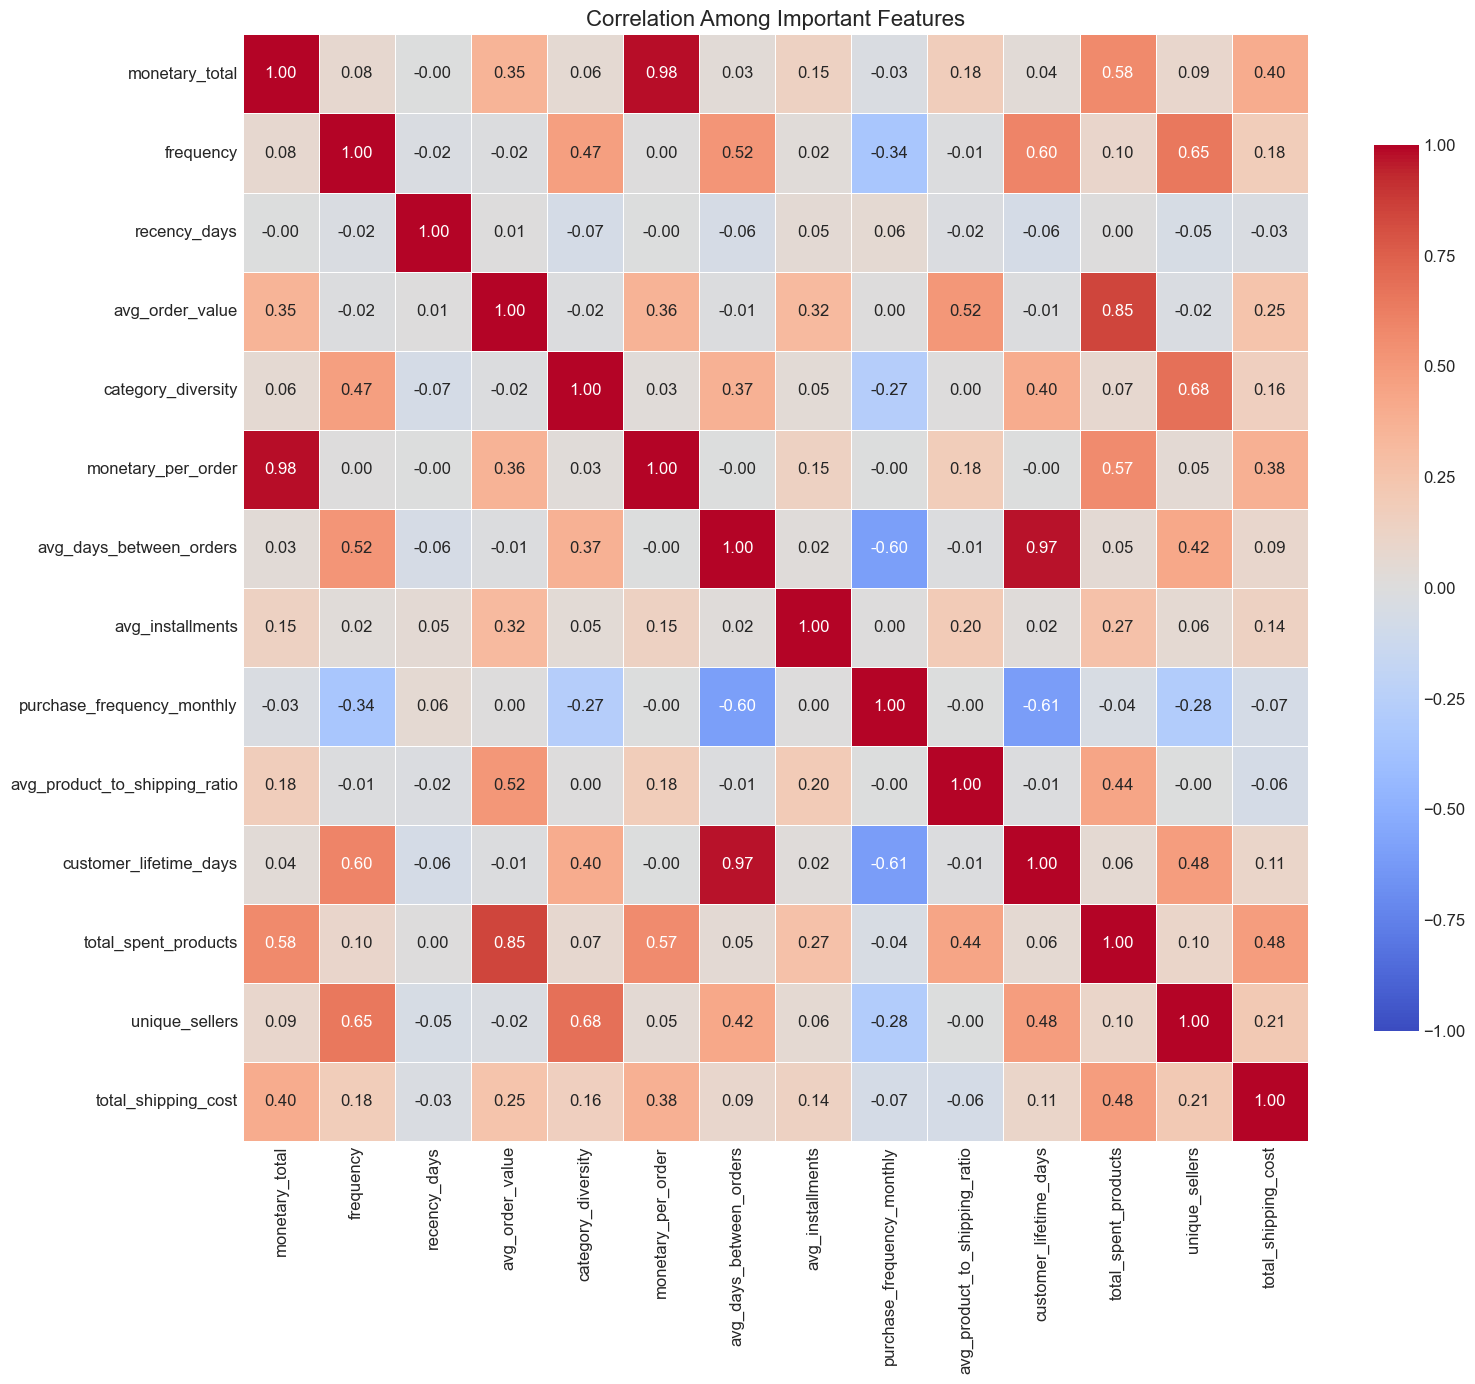

In [45]:
# Analyze correlations
target_correlations, correlation_matrix = analyze_correlations(customer_rfm)

# Feature selection for customer segmentation

In [46]:
def select_important_features(customer_df):
   from sklearn.preprocessing import StandardScaler
   from sklearn.decomposition import PCA
   from sklearn.ensemble import RandomForestRegressor
   from sklearn.feature_selection import mutual_info_regression
   
   # Remove non-numeric columns for analysis
   X = customer_df.select_dtypes(include=['float64', 'int64'])
   
   # Handle missing values if any
   X = X.fillna(X.median())
   
   # Define potential target variables
   target_variables = ['monetary_total', 'frequency', 'recency_days', 'avg_order_value']
   
   # Store results
   importance_results = {}
   
   print("Feature Importance Analysis:")
   print("--------------------------")
   
   # 1. Random Forest Feature Importance
   for target in target_variables:
       # Separate features and target
       y = X[target]
       X_features = X.drop(target_variables, axis=1)  # Drop all targets to avoid leakage
       
       # Scale features for better modeling
       scaler = StandardScaler()
       X_scaled = scaler.fit_transform(X_features)
       
       # Train Random Forest model
       rf = RandomForestRegressor(n_estimators=100, random_state=42)
       rf.fit(X_scaled, y)
       
       # Get feature importance
       feature_importance = pd.DataFrame({
           'Feature': X_features.columns,
           'Importance': rf.feature_importances_
       }).sort_values('Importance', ascending=False)
       
       # Store results
       importance_results[f'{target}_rf'] = feature_importance
       
       # Print top 5 features
       print(f"\nTop 5 features for predicting {target} (Random Forest):")
       print(feature_importance.head(5))
       
       # Plot feature importance
       plt.figure(figsize=(10, 6))
       sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
       plt.title(f'Top 10 Features for Predicting {target} (Random Forest)', size=16)
       plt.grid(axis='x', linestyle='--', alpha=0.7)
       plt.tight_layout()
       plt.show()
   
   # 2. Mutual Information (for non-linear relationships)
   for target in target_variables:
       # Separate features and target
       y = X[target]
       X_features = X.drop(target_variables, axis=1)
       
       # Calculate mutual information
       mi_scores = mutual_info_regression(X_features, y, random_state=42)
       
       # Create DataFrame with results
       mi_importance = pd.DataFrame({
           'Feature': X_features.columns,
           'MI_Score': mi_scores
       }).sort_values('MI_Score', ascending=False)
       
       # Store results
       importance_results[f'{target}_mi'] = mi_importance
       
       # Print top 5 features
       print(f"\nTop 5 features for predicting {target} (Mutual Information):")
       print(mi_importance.head(5))
       
       # Plot mutual information scores
       plt.figure(figsize=(10, 6))
       sns.barplot(x='MI_Score', y='Feature', data=mi_importance.head(10))
       plt.title(f'Top 10 Features for Predicting {target} (Mutual Information)', size=16)
       plt.grid(axis='x', linestyle='--', alpha=0.7)
       plt.tight_layout()
       plt.show()
   
   # 3. Principal Component Analysis to identify important feature combinations
   X_for_pca = X.drop(target_variables, axis=1)
   scaler = StandardScaler()
   X_scaled = scaler.fit_transform(X_for_pca)
   
   # Apply PCA
   pca = PCA()
   pca.fit(X_scaled)
   
   # Plot explained variance ratio
   plt.figure(figsize=(10, 6))
   plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
   plt.axhline(y=0.9, color='r', linestyle='--', label='90% Explained Variance')
   plt.title('Cumulative Explained Variance by Components', size=16)
   plt.xlabel('Number of Components')
   plt.ylabel('Cumulative Explained Variance')
   plt.grid(True, linestyle='--', alpha=0.7)
   plt.legend()
   plt.tight_layout()
   plt.show()
   
   # Get the number of components needed to explain 90% of variance
   n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.9) + 1
   print(f"\nNumber of PCA components needed to explain 90% of variance: {n_components}")
   
   # Look at feature weights for the first few principal components
   n_display = min(3, len(pca.components_))
   component_df = pd.DataFrame()
   
   for i in range(n_display):
       component_df[f'PC{i+1}'] = pca.components_[i]
   
   component_df['Feature'] = X_for_pca.columns
   component_df = component_df.set_index('Feature')
   
   # Display component loadings
   print("\nPrincipal Component Loadings (absolute values):")
   print(component_df.abs().sort_values(by='PC1', ascending=False).head(10))
   
   # Plot heatmap of component loadings
   plt.figure(figsize=(12, 8))
   sns.heatmap(
       component_df.abs(), 
       cmap='viridis', 
       annot=True, 
       fmt='.2f'
   )
   plt.title('PCA Component Loadings (Absolute Values)', size=16)
   plt.tight_layout()
   plt.show()
   
   # 4. Create a composite feature importance score
   # Combine RF and MI scores for a more robust ranking
   composite_scores = {}
   
   for feature in X_for_pca.columns:
       composite_scores[feature] = 0
       
       # Add normalized scores from all methods
       for target in target_variables:
           # RF scores
           rf_max = importance_results[f'{target}_rf']['Importance'].max()
           rf_score = importance_results[f'{target}_rf'][
               importance_results[f'{target}_rf']['Feature'] == feature
           ]['Importance'].values
           if len(rf_score) > 0:
               composite_scores[feature] += rf_score[0] / rf_max
           
           # MI scores
           mi_max = importance_results[f'{target}_mi']['MI_Score'].max()
           mi_score = importance_results[f'{target}_mi'][
               importance_results[f'{target}_mi']['Feature'] == feature
           ]['MI_Score'].values
           if len(mi_score) > 0 and mi_max > 0:  # Avoid division by zero
               composite_scores[feature] += mi_score[0] / mi_max
   
   # Create DataFrame with composite scores
   composite_df = pd.DataFrame({
       'Feature': list(composite_scores.keys()),
       'Composite_Score': list(composite_scores.values())
   }).sort_values('Composite_Score', ascending=False)
   
   print("\nTop 10 features by composite importance score:")
   print(composite_df.head(10))
   
   # Plot composite scores
   plt.figure(figsize=(10, 6))
   sns.barplot(x='Composite_Score', y='Feature', data=composite_df.head(15))
   plt.title('Top 15 Features by Composite Importance Score', size=16)
   plt.grid(axis='x', linestyle='--', alpha=0.7)
   plt.tight_layout()
   plt.show()
   
   # Return the recommended set of features for segmentation
   recommended_features = composite_df.head(10)['Feature'].tolist()
   print("\nRecommended features for customer segmentation:")
   print(recommended_features)
   
   return composite_df, recommended_features, importance_results

Feature Importance Analysis:
--------------------------

Top 5 features for predicting monetary_total (Random Forest):
                      Feature  Importance
9          monetary_per_order    0.932760
1        total_spent_products    0.033933
0      customer_lifetime_days    0.012918
8  purchase_frequency_monthly    0.007545
6     avg_days_between_orders    0.004455


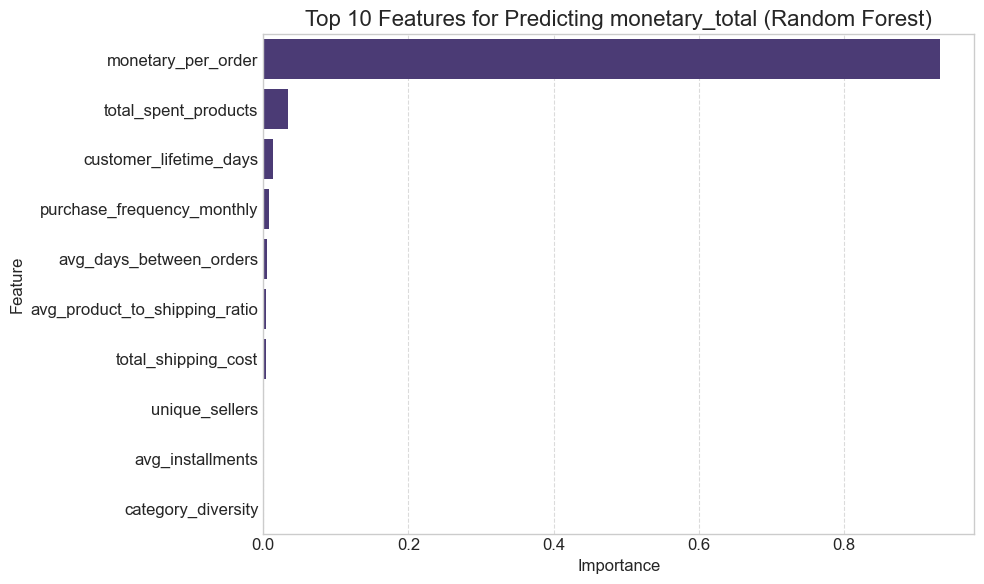


Top 5 features for predicting frequency (Random Forest):
                      Feature  Importance
0      customer_lifetime_days    0.578533
8  purchase_frequency_monthly    0.221269
4              unique_sellers    0.109429
6     avg_days_between_orders    0.049231
9          monetary_per_order    0.017125


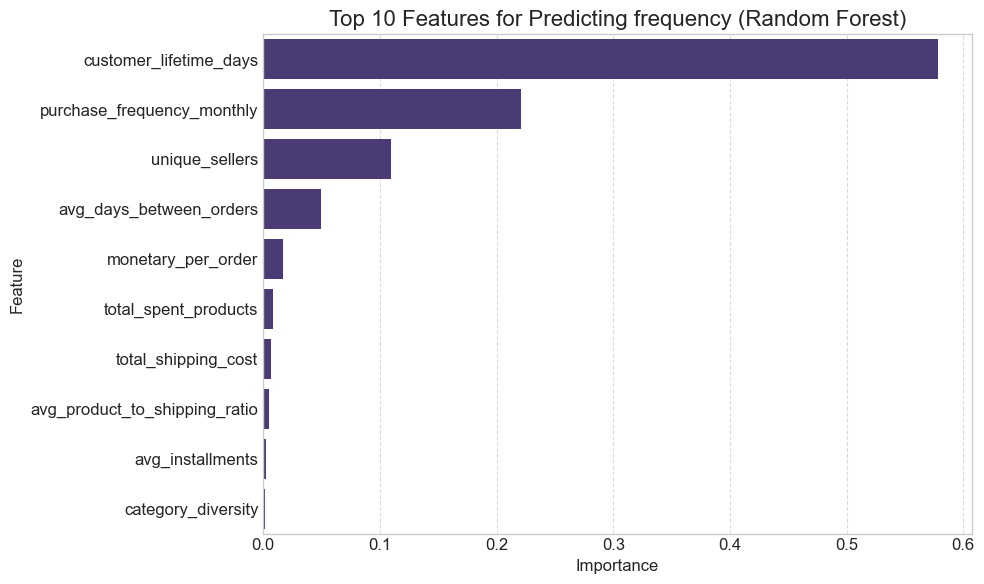


Top 5 features for predicting recency_days (Random Forest):
                         Feature  Importance
2            total_shipping_cost    0.432250
7  avg_product_to_shipping_ratio    0.198204
9             monetary_per_order    0.186726
1           total_spent_products    0.106511
5               avg_installments    0.055589


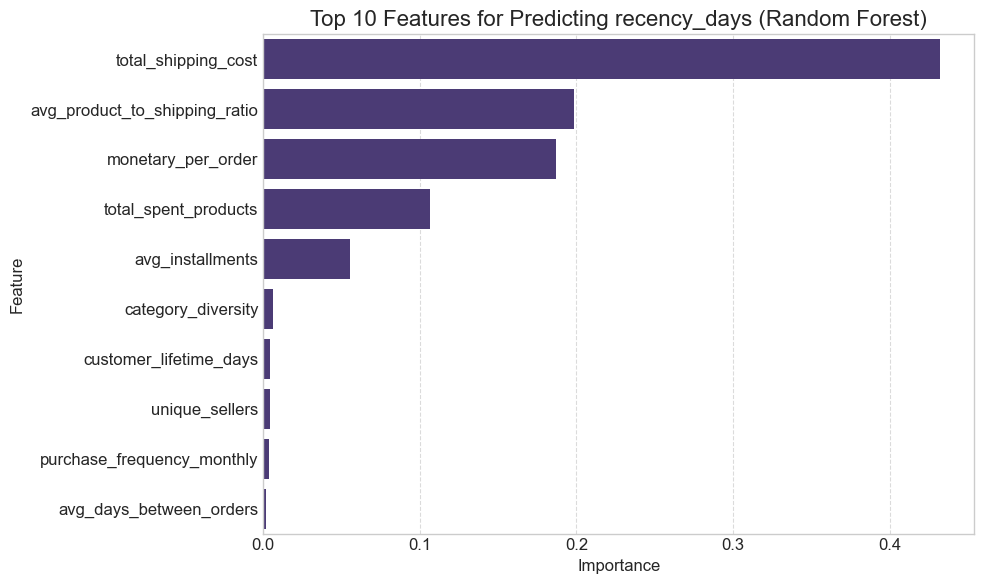


Top 5 features for predicting avg_order_value (Random Forest):
                         Feature  Importance
1           total_spent_products    0.823542
9             monetary_per_order    0.157036
7  avg_product_to_shipping_ratio    0.005440
4                 unique_sellers    0.005177
2            total_shipping_cost    0.002892


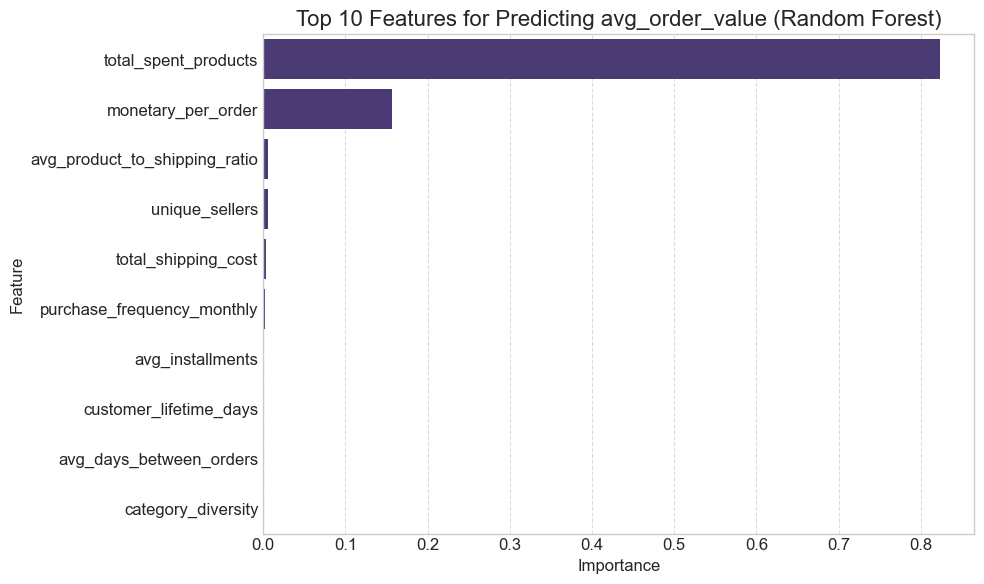


Top 5 features for predicting monetary_total (Mutual Information):
                         Feature  MI_Score
9             monetary_per_order  9.006276
7  avg_product_to_shipping_ratio  4.182430
1           total_spent_products  3.385340
2            total_shipping_cost  3.196405
5               avg_installments  0.202749


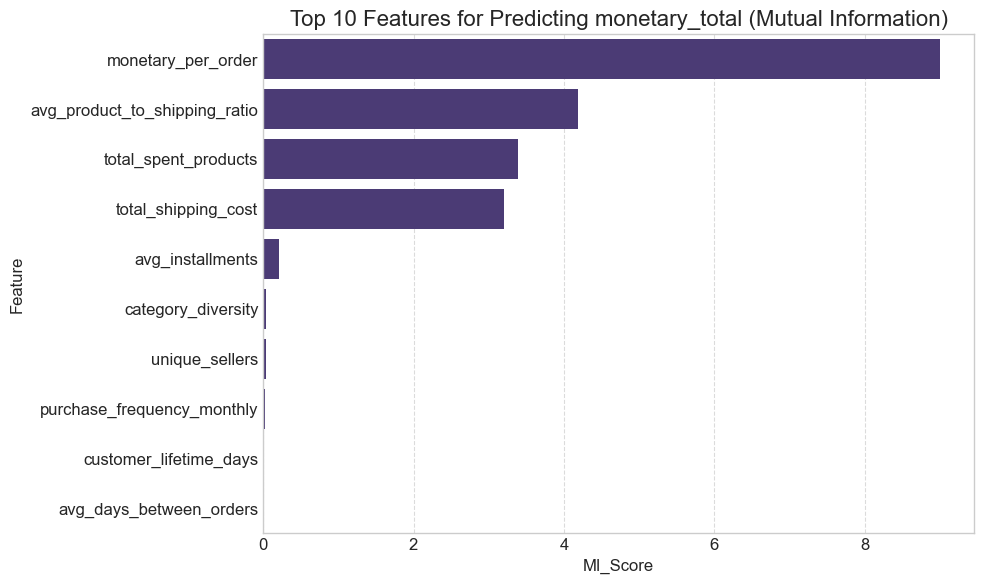


Top 5 features for predicting frequency (Mutual Information):
                      Feature  MI_Score
8  purchase_frequency_monthly  0.134756
0      customer_lifetime_days  0.090293
6     avg_days_between_orders  0.087267
4              unique_sellers  0.075375
3          category_diversity  0.050186


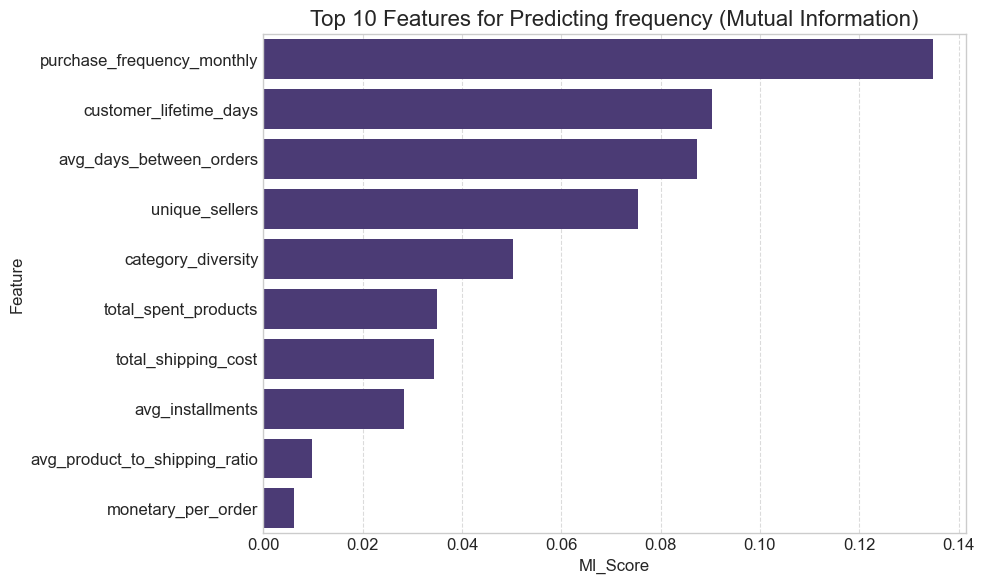


Top 5 features for predicting recency_days (Mutual Information):
                         Feature  MI_Score
2            total_shipping_cost  0.273935
1           total_spent_products  0.099736
7  avg_product_to_shipping_ratio  0.082140
9             monetary_per_order  0.060841
4                 unique_sellers  0.007307


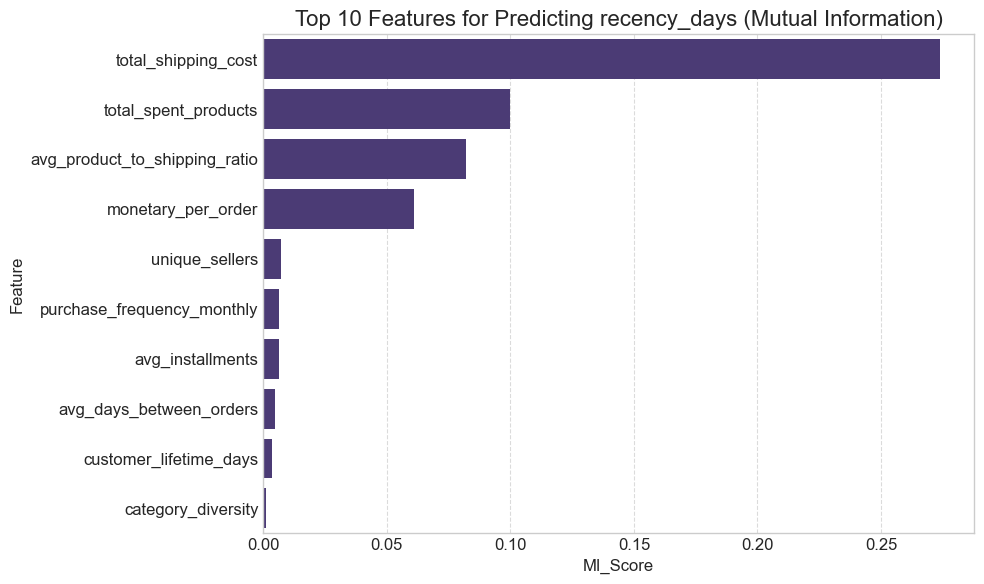


Top 5 features for predicting avg_order_value (Mutual Information):
                         Feature  MI_Score
1           total_spent_products  6.202171
9             monetary_per_order  3.464565
7  avg_product_to_shipping_ratio  3.251523
2            total_shipping_cost  1.617697
5               avg_installments  0.139445


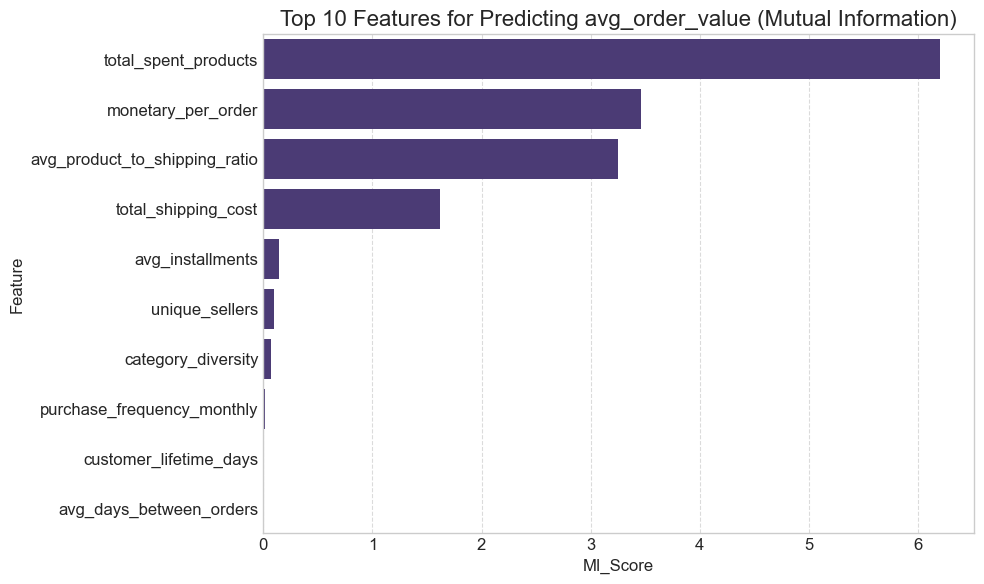

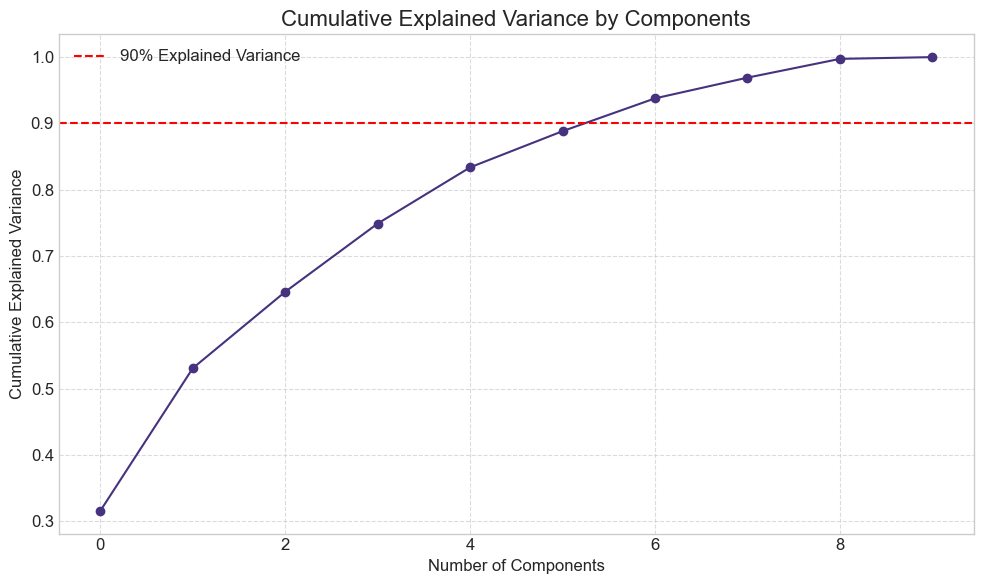


Number of PCA components needed to explain 90% of variance: 7

Principal Component Loadings (absolute values):
                                    PC1       PC2       PC3
Feature                                                    
customer_lifetime_days         0.499890  0.155608  0.204483
avg_days_between_orders        0.486614  0.159965  0.236624
unique_sellers                 0.402360  0.016156  0.358305
purchase_frequency_monthly     0.384371  0.133087  0.269314
category_diversity             0.372945  0.031825  0.366976
total_shipping_cost            0.175990  0.383068  0.442844
total_spent_products           0.142299  0.579248  0.085489
monetary_per_order             0.088256  0.499847  0.077958
avg_installments               0.066184  0.296614  0.200544
avg_product_to_shipping_ratio  0.034690  0.333339  0.562936


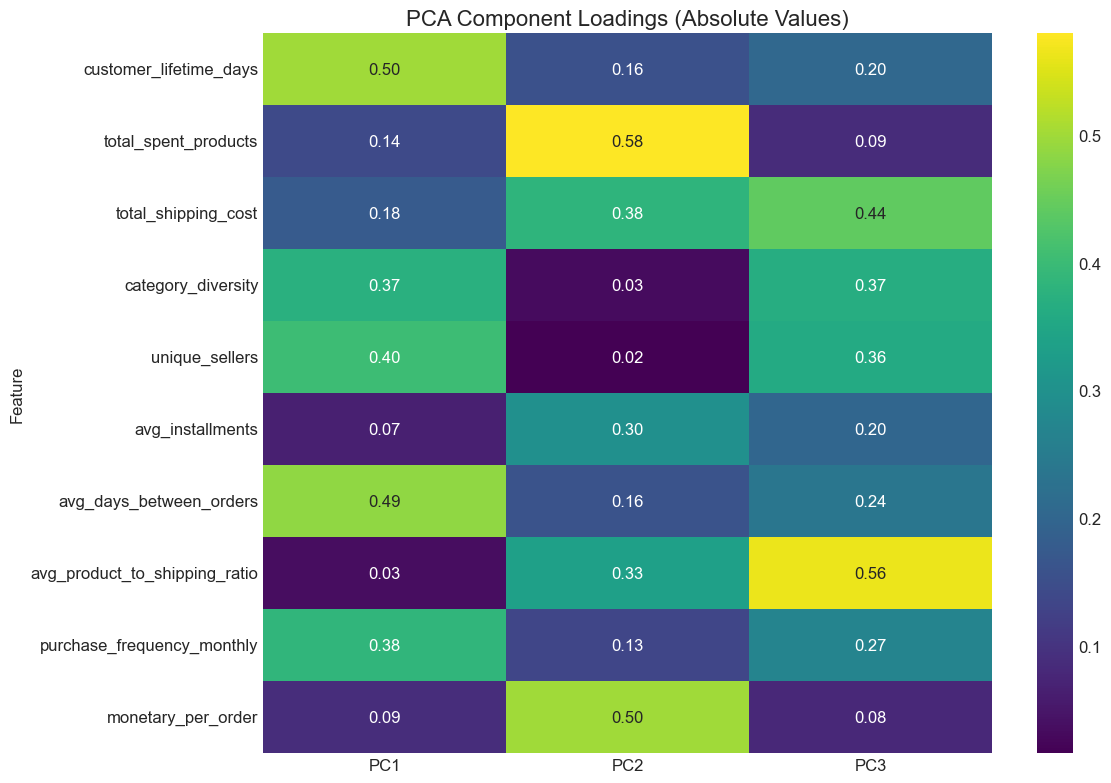


Top 10 features by composite importance score:
                         Feature  Composite_Score
9             monetary_per_order         3.478827
1           total_spent_products         3.296513
2            total_shipping_cost         2.890224
7  avg_product_to_shipping_ratio         1.839839
0         customer_lifetime_days         1.711825
8     purchase_frequency_monthly         1.430359
4                 unique_sellers         0.810421
6        avg_days_between_orders         0.763458
5               avg_installments         0.413326
3             category_diversity         0.409021


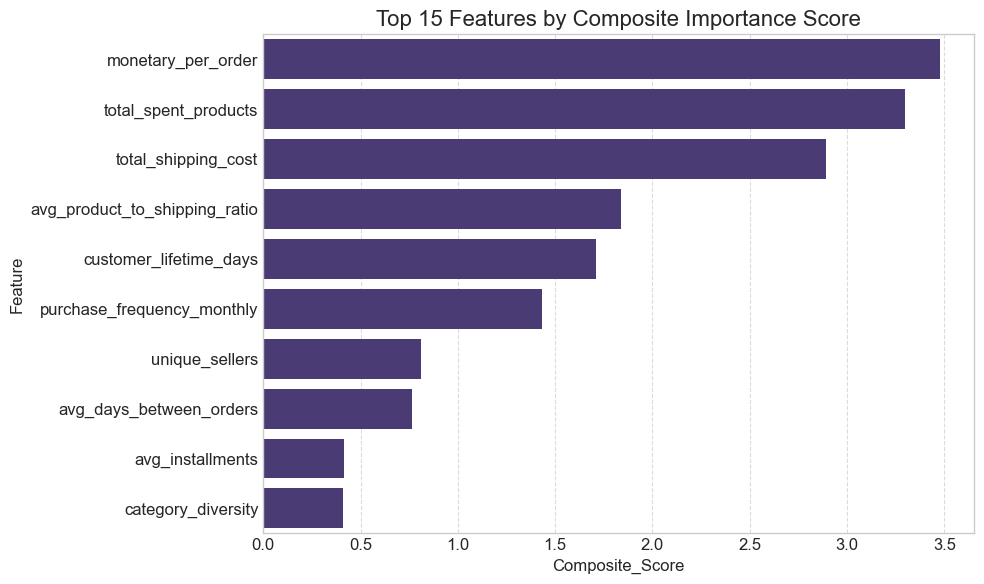


Recommended features for customer segmentation:
['monetary_per_order', 'total_spent_products', 'total_shipping_cost', 'avg_product_to_shipping_ratio', 'customer_lifetime_days', 'purchase_frequency_monthly', 'unique_sellers', 'avg_days_between_orders', 'avg_installments', 'category_diversity']


In [47]:
# Select important features
composite_importance, recommended_features, importance_details = select_important_features(customer_rfm)

# Enhanced visualizations for customer segmentation

In [48]:
def create_enhanced_visualizations(df, customer_df, recommended_features):
   # 1. RFM Segments Visualization
   # Quantile-based discretization for RFM
   quantiles = customer_df[['recency_days', 'frequency', 'monetary_total']].quantile(
       q=[0.25, 0.5, 0.75]
   ).to_dict()
   
   # Define RFM segmentation functions
   def r_score(x, p, d):
       if x <= d[p][0.25]:
           return 4  # best - lowest recency (most recent)
       elif x <= d[p][0.50]:
           return 3
       elif x <= d[p][0.75]:
           return 2
       else:
           return 1  # worst - highest recency (least recent)
           
   def fm_score(x, p, d):
       if x <= d[p][0.25]:
           return 1  # worst - lowest frequency/monetary
       elif x <= d[p][0.50]:
           return 2
       elif x <= d[p][0.75]:
           return 3
       else:
           return 4  # best - highest frequency/monetary
   
   # Calculate RFM scores
   customer_df['R_Score'] = customer_df['recency_days'].apply(lambda x: r_score(x, 'recency_days', quantiles))
   customer_df['F_Score'] = customer_df['frequency'].apply(lambda x: fm_score(x, 'frequency', quantiles))
   customer_df['M_Score'] = customer_df['monetary_total'].apply(lambda x: fm_score(x, 'monetary_total', quantiles))
   
   # Calculate RFM combined score and segment
   customer_df['RFM_Score'] = customer_df['R_Score'].astype(str) + customer_df['F_Score'].astype(str) + customer_df['M_Score'].astype(str)
   
   # Define customer segments based on RFM scores
   def segment_customer(rfm_score):
       r = int(rfm_score[0])
       f = int(rfm_score[1])
       m = int(rfm_score[2])
       
       if r >= 3 and f >= 3 and m >= 3:
           return 'Champions'
       elif r >= 3 and f >= 1 and m >= 3:
           return 'Loyal Customers'
       elif r >= 3 and f >= 3 and m < 3:
           return 'Potential Loyalists'
       elif r >= 3 and f < 3 and m < 3:
           return 'New Customers'
       elif r < 3 and f >= 3 and m >= 3:
           return 'At Risk Customers'
       elif r < 3 and f >= 3 and m < 3:
           return 'Need Attention'
       elif r < 3 and f < 3 and m >= 3:
           return 'Dormant'
       else:
           return 'Lost Customers'
   
   customer_df['Customer_Segment'] = customer_df['RFM_Score'].apply(segment_customer)
   
   # Visualize customer segments
   segment_counts = customer_df['Customer_Segment'].value_counts()
   
   plt.figure(figsize=(12, 8))
   ax = sns.barplot(x=segment_counts.index, y=segment_counts.values, palette='viridis')
   plt.title('Customer Segments Based on RFM Analysis', size=16)
   plt.xlabel('Segment')
   plt.ylabel('Number of Customers')
   plt.xticks(rotation=45, ha='right')
   
   # Add value labels on top of bars
   for i, v in enumerate(segment_counts.values):
       ax.text(i, v + 5, str(v), ha='center')
   
   plt.grid(axis='y', linestyle='--', alpha=0.7)
   plt.tight_layout()
   plt.show()
   
   # 2. 3D Scatter Plot for RFM dimensions
   from mpl_toolkits.mplot3d import Axes3D
   
   # Sample the dataset if it's too large
   sample_size = min(1000, len(customer_df))
   df_sample = customer_df.sample(sample_size, random_state=42)
   
   # Create figure
   fig = plt.figure(figsize=(12, 10))
   ax = fig.add_subplot(111, projection='3d')
   
   # Create scatter plot
   scatter = ax.scatter(
       df_sample['recency_days'],
       df_sample['frequency'],
       df_sample['monetary_total'],
       c=df_sample['Customer_Segment'].astype('category').cat.codes,
       cmap='viridis',
       s=50,
       alpha=0.7
   )
   
   # Add labels
   ax.set_xlabel('Recency (days)', fontsize=12)
   ax.set_ylabel('Frequency', fontsize=12)
   ax.set_zlabel('Monetary', fontsize=12)
   plt.title('3D Visualization of RFM Segments', size=16)
   
   # Add legend with unique segments
   legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                         label=segment,
                         markerfacecolor=plt.cm.viridis(i / len(df_sample['Customer_Segment'].unique())), 
                         markersize=10)
                   for i, segment in enumerate(df_sample['Customer_Segment'].unique())]
   
   ax.legend(handles=legend_elements, title="Segments", loc="upper right")
   
   plt.tight_layout()
   plt.show()
   
   # 3. Customer Cohort Analysis by first purchase month
   # Add first purchase date for each customer
   first_purchases = df.groupby('customer_unique_id')['order_purchase_timestamp'].min().reset_index()
   first_purchases.columns = ['customer_unique_id', 'first_purchase_date']
   
   # Merge with customer_df
   customer_cohort = customer_df.merge(first_purchases, on='customer_unique_id')
   
   # Extract year and month of first purchase for cohort
   customer_cohort['cohort_year'] = customer_cohort['first_purchase_date'].dt.year
   customer_cohort['cohort_month'] = customer_cohort['first_purchase_date'].dt.month
   customer_cohort['cohort'] = customer_cohort['cohort_year'].astype(str) + '-' + customer_cohort['cohort_month'].astype(str).str.zfill(2)
   
   # Count customers by cohort
   cohort_counts = customer_cohort.groupby('cohort').size().reset_index(name='customer_count')
   
   # Get average metrics by cohort
   cohort_metrics = customer_cohort.groupby('cohort').agg({
       'frequency': 'mean',
       'monetary_total': 'mean',
       'avg_order_value': 'mean'
   }).reset_index()
   
   # Merge counts and metrics
   cohort_analysis = cohort_counts.merge(cohort_metrics, on='cohort')
   
   # Filter to top 12 cohorts by customer count
   top_cohorts = cohort_analysis.sort_values('customer_count', ascending=False).head(12)
   
   # Plot cohort analysis
   fig, axes = plt.subplots(2, 2, figsize=(18, 12))
   
   # Customer count by cohort
   sns.barplot(x='cohort', y='customer_count', data=top_cohorts, ax=axes[0, 0])
   axes[0, 0].set_title('Customer Count by Cohort', size=14)
   axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=45, ha='right')
   axes[0, 0].grid(axis='y', linestyle='--', alpha=0.7)
   
   # Average frequency by cohort
   sns.barplot(x='cohort', y='frequency', data=top_cohorts, ax=axes[0, 1])
   axes[0, 1].set_title('Average Frequency by Cohort', size=14)
   axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=45, ha='right')
   axes[0, 1].grid(axis='y', linestyle='--', alpha=0.7)
   
   # Average monetary value by cohort
   sns.barplot(x='cohort', y='monetary_total', data=top_cohorts, ax=axes[1, 0])
   axes[1, 0].set_title('Average Monetary Value by Cohort', size=14)
   axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=45, ha='right')
   axes[1, 0].grid(axis='y', linestyle='--', alpha=0.7)
   
   # Average order value by cohort
   sns.barplot(x='cohort', y='avg_order_value', data=top_cohorts, ax=axes[1, 1])
   axes[1, 1].set_title('Average Order Value by Cohort', size=14)
   axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=45, ha='right')
   axes[1, 1].grid(axis='y', linestyle='--', alpha=0.7)
   
   plt.suptitle('Customer Cohort Analysis', size=18)
   plt.tight_layout()
   plt.subplots_adjust(top=0.9)
   plt.show()
   
   return customer_df

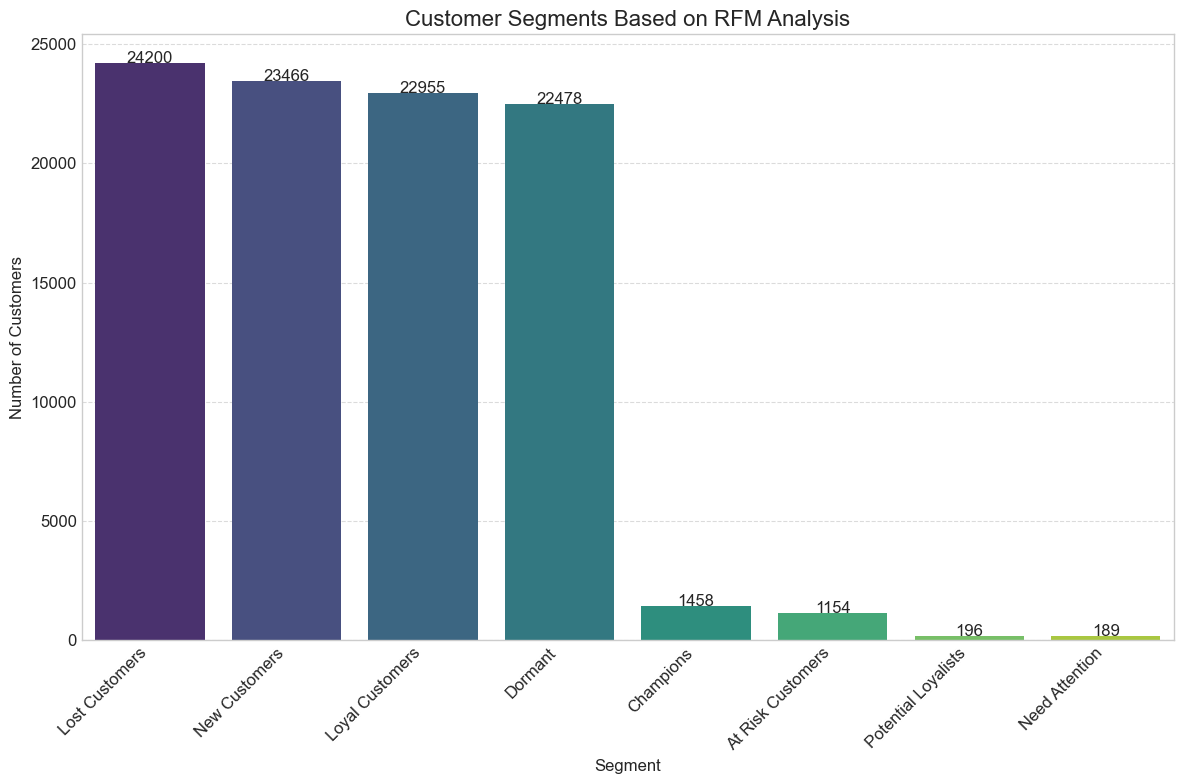

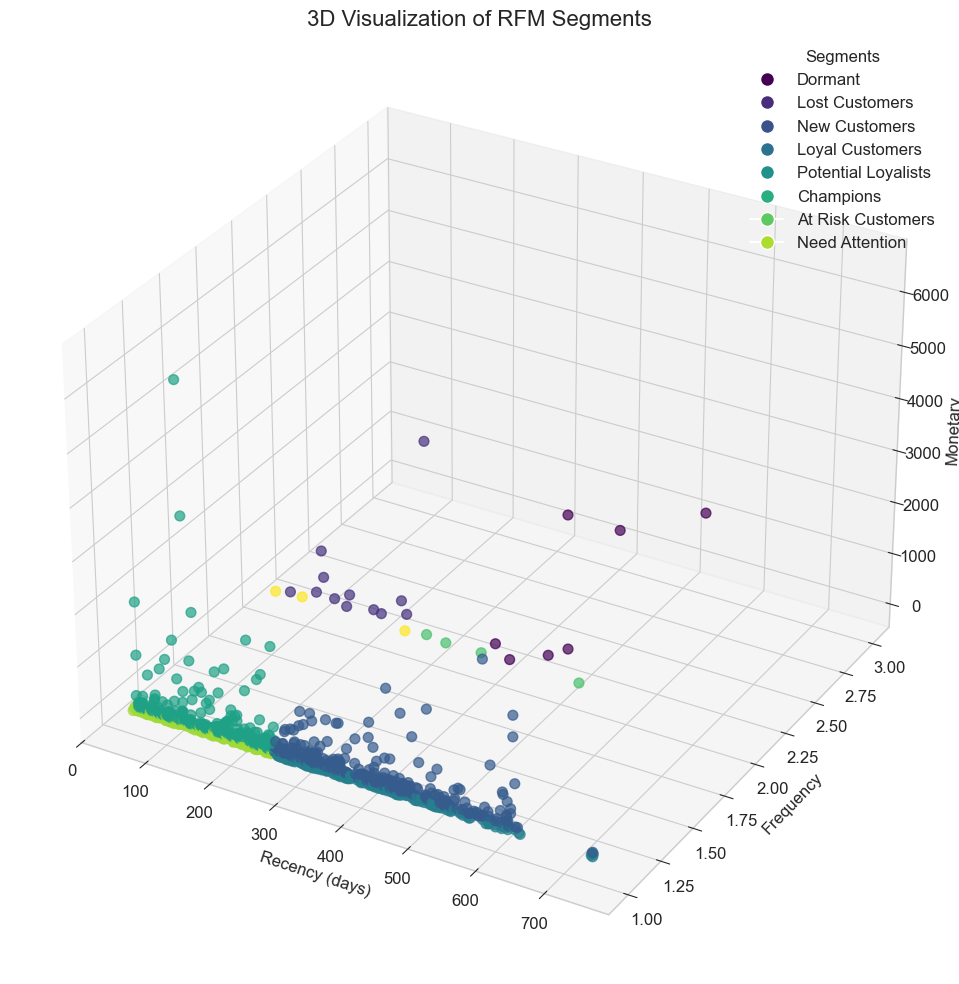

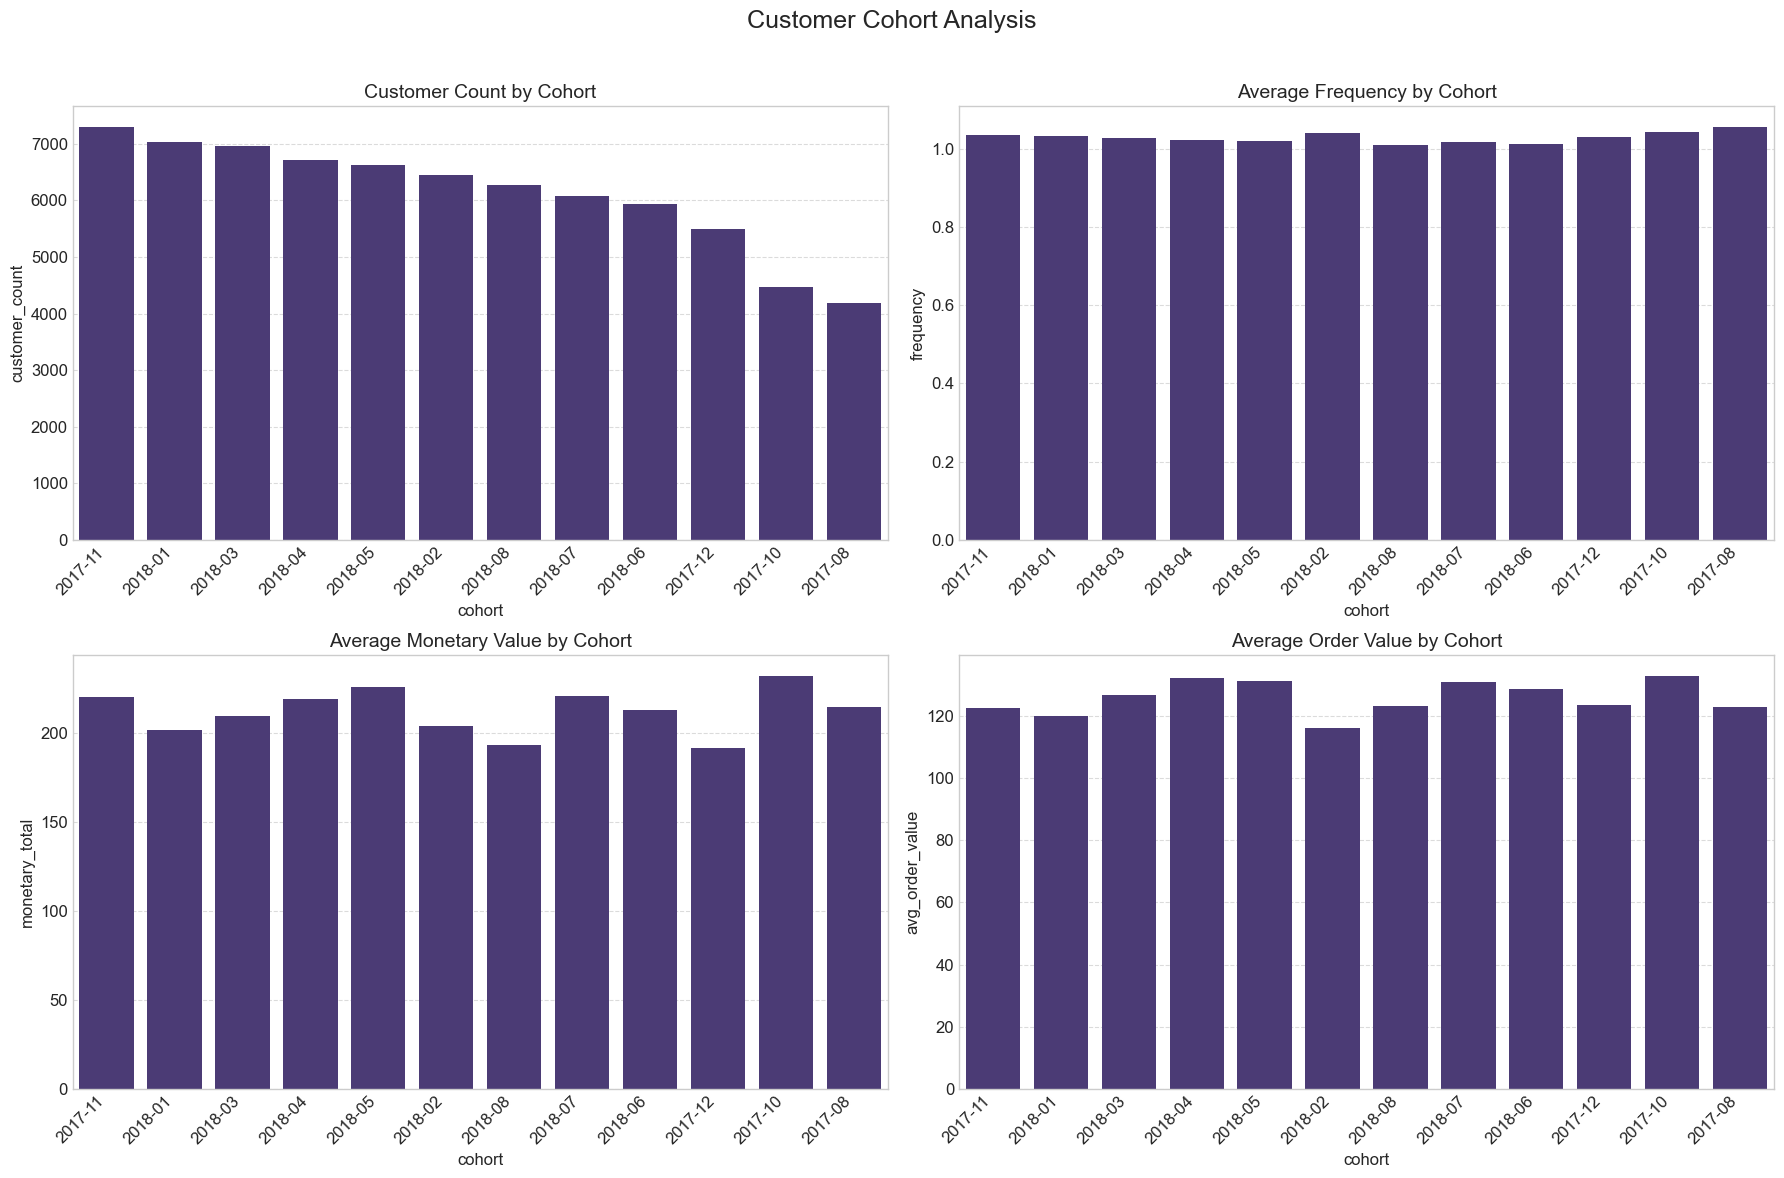

In [49]:
# Create enhanced visualizations
customer_df_with_segments = create_enhanced_visualizations(df, customer_rfm, recommended_features)

# Prepare data for final customer segmentation

In [50]:
def prepare_segmentation_data(customer_df, recommended_features):
   from sklearn.preprocessing import StandardScaler
   from sklearn.cluster import KMeans
   from sklearn.metrics import silhouette_score
   from sklearn.decomposition import PCA
   
   # Select recommended features for segmentation
   X = customer_df[recommended_features].copy()
   
   # Handle missing values
   X = X.fillna(X.median())
   
   # Standardize the features
   scaler = StandardScaler()
   X_scaled = scaler.fit_transform(X)
   
   # Apply PCA for dimensionality reduction and visualization
   pca = PCA(n_components=2)
   X_pca = pca.fit_transform(X_scaled)
   
   # Create a DataFrame for visualization
   pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
   pca_df['customer_unique_id'] = customer_df['customer_unique_id'].values
   
   # Determine optimal number of clusters
   silhouette_scores = []
   inertia = []
   
   K_range = range(2, 11)
   for k in K_range:
       kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
       kmeans.fit(X_scaled)
       
       silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))
       inertia.append(kmeans.inertia_)
   
   # Plot silhouette scores and elbow method
   fig, axes = plt.subplots(1, 2, figsize=(16, 6))
   
   # Silhouette score (higher is better)
   axes[0].plot(K_range, silhouette_scores, 'bo-')
   axes[0].set_xlabel('Number of Clusters')
   axes[0].set_ylabel('Silhouette Score')
   axes[0].set_title('Silhouette Score by Number of Clusters')
   axes[0].grid(True, linestyle='--', alpha=0.7)
   
   # Elbow method (looking for the "elbow" point)
   axes[1].plot(K_range, inertia, 'ro-')
   axes[1].set_xlabel('Number of Clusters')
   axes[1].set_ylabel('Inertia (Sum of Squared Distances)')
   axes[1].set_title('Elbow Method for Optimal k')
   axes[1].grid(True, linestyle='--', alpha=0.7)
   
   plt.tight_layout()
   plt.show()
   
   # Get the optimal k based on silhouette score
   optimal_k = K_range[np.argmax(silhouette_scores)]
   print(f"Optimal number of clusters based on silhouette score: {optimal_k}")
   
   # Apply K-means with optimal number of clusters
   kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
   cluster_labels = kmeans.fit_predict(X_scaled)
   
   # Add cluster labels to PCA and original data
   pca_df['Cluster'] = cluster_labels
   customer_df['ML_Cluster'] = cluster_labels
   
   # Visualize clusters in 2D PCA space
   plt.figure(figsize=(12, 8))
   
   # Plot each cluster with a different color
   for cluster in range(optimal_k):
       plt.scatter(
           pca_df[pca_df['Cluster'] == cluster]['PC1'],
           pca_df[pca_df['Cluster'] == cluster]['PC2'],
           label=f'Cluster {cluster}',
           alpha=0.7,
           s=80
       )
   
   # Add cluster centers
   centers_pca = pca.transform(kmeans.cluster_centers_)
   plt.scatter(
       centers_pca[:, 0], centers_pca[:, 1],
       s=250, marker='X', c='black',
       label='Cluster Centers'
   )
   
   plt.title('Customer Segments in 2D PCA Space', size=16)
   plt.xlabel('Principal Component 1')
   plt.ylabel('Principal Component 2')
   plt.legend()
   plt.grid(True, linestyle='--', alpha=0.7)
   plt.tight_layout()
   plt.show()
   
       # Compare ML clusters with RFM segments
   if 'Customer_Segment' in customer_df.columns:
       cluster_segment_counts = pd.crosstab(
           customer_df['ML_Cluster'], 
           customer_df['Customer_Segment'],
           normalize='index'
       )
       
       # Visualize the comparison
       plt.figure(figsize=(14, 10))
       sns.heatmap(
           cluster_segment_counts, 
           annot=True, 
           cmap='YlGnBu', 
           fmt='.2f',
           linewidths=0.5
       )
       plt.title('ML Clusters vs. RFM Segments', size=16)
       plt.xlabel('RFM Segment')
       plt.ylabel('ML Cluster')
       plt.tight_layout()
       plt.show()
       
   # Analyze cluster characteristics
   cluster_profiles = customer_df.groupby('ML_Cluster')[recommended_features].mean()
   
   # Normalize the profiles for comparison
   cluster_profiles_norm = (cluster_profiles - cluster_profiles.min()) / (cluster_profiles.max() - cluster_profiles.min())
   
   # Display cluster profiles
   print("\nCluster Profiles (normalized):")
   print(cluster_profiles_norm)
   
   # Visualize cluster profiles
   plt.figure(figsize=(16, 8))
   sns.heatmap(
       cluster_profiles_norm, 
       annot=True, 
       cmap='YlGnBu', 
       fmt='.2f',
       linewidths=0.5
   )
   plt.title('Normalized Cluster Profiles', size=16)
   plt.tight_layout()
   plt.show()
   
   # Create descriptive names for each cluster based on their characteristics
   cluster_names = {}
   
   for cluster in range(optimal_k):
       profile = cluster_profiles.loc[cluster]
       
       # Find the top 3 features for this cluster
       top_features = profile.nlargest(3).index.tolist()
       
       # Check if recency is high (meaning less recent purchases)
       high_recency = 'recency_days' in profile.nlargest(3).index
       
       # Check if monetary and frequency metrics are high
       high_monetary = 'monetary_total' in profile.nlargest(3).index
       high_frequency = 'frequency' in profile.nlargest(3).index
       
       # Create descriptive names based on characteristics
       if high_monetary and high_frequency and not high_recency:
           cluster_names[cluster] = "High Value Active Customers"
       elif high_monetary and not high_frequency:
           cluster_names[cluster] = "Big Spenders (Infrequent)"
       elif high_frequency and not high_monetary:
           cluster_names[cluster] = "Frequent Small Purchasers"
       elif high_recency:
           cluster_names[cluster] = "Inactive Customers"
       else:
           # Custom name based on top features
           feature_names = [f.replace('_', ' ').title() for f in top_features]
           cluster_names[cluster] = f"High {' & '.join(feature_names[:2])} Customers"
   
   # Add descriptive names to the dataframe
   customer_df['Cluster_Name'] = customer_df['ML_Cluster'].map(cluster_names)
   
   # Display cluster names and sizes
   cluster_sizes = customer_df['Cluster_Name'].value_counts()
   
   plt.figure(figsize=(12, 6))
   sns.barplot(x=cluster_sizes.index, y=cluster_sizes.values)
   plt.title('Customer Segments Size', size=16)
   plt.xlabel('Segment')
   plt.ylabel('Number of Customers')
   plt.xticks(rotation=45, ha='right')
   plt.grid(axis='y', linestyle='--', alpha=0.7)
   plt.tight_layout()
   plt.show()
   
   return customer_df, kmeans, scaler, cluster_names

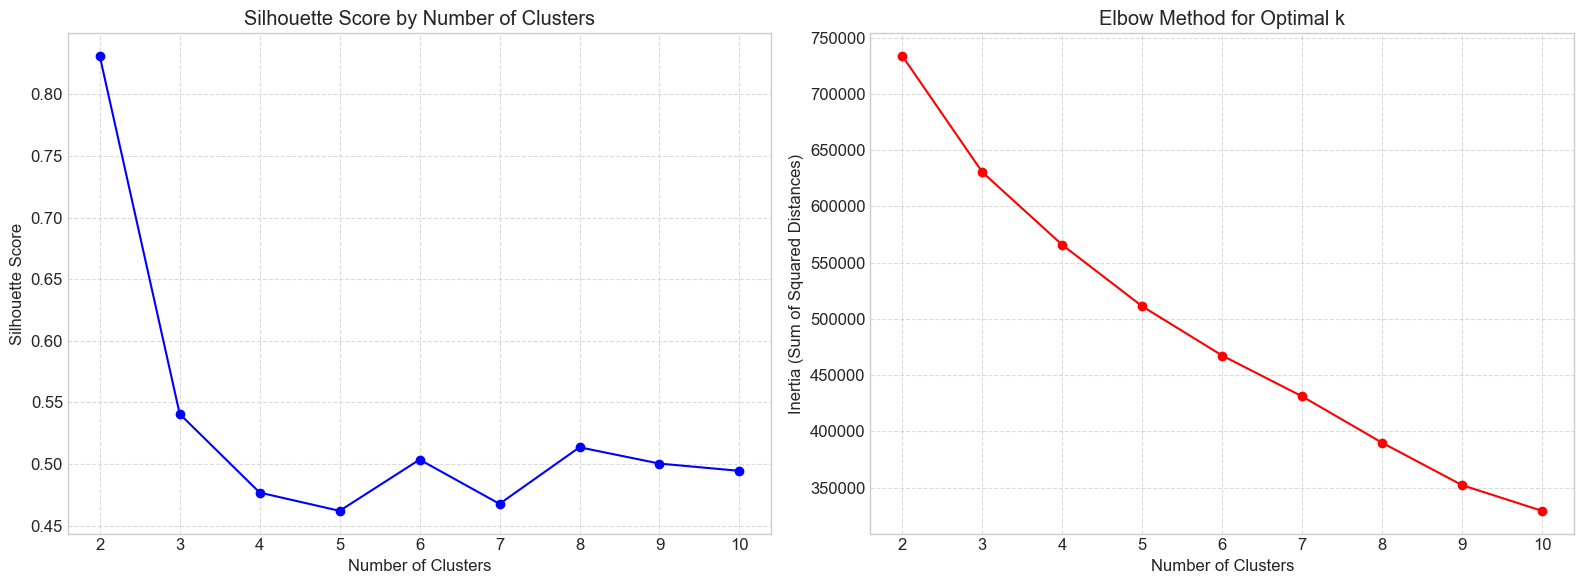

Optimal number of clusters based on silhouette score: 2


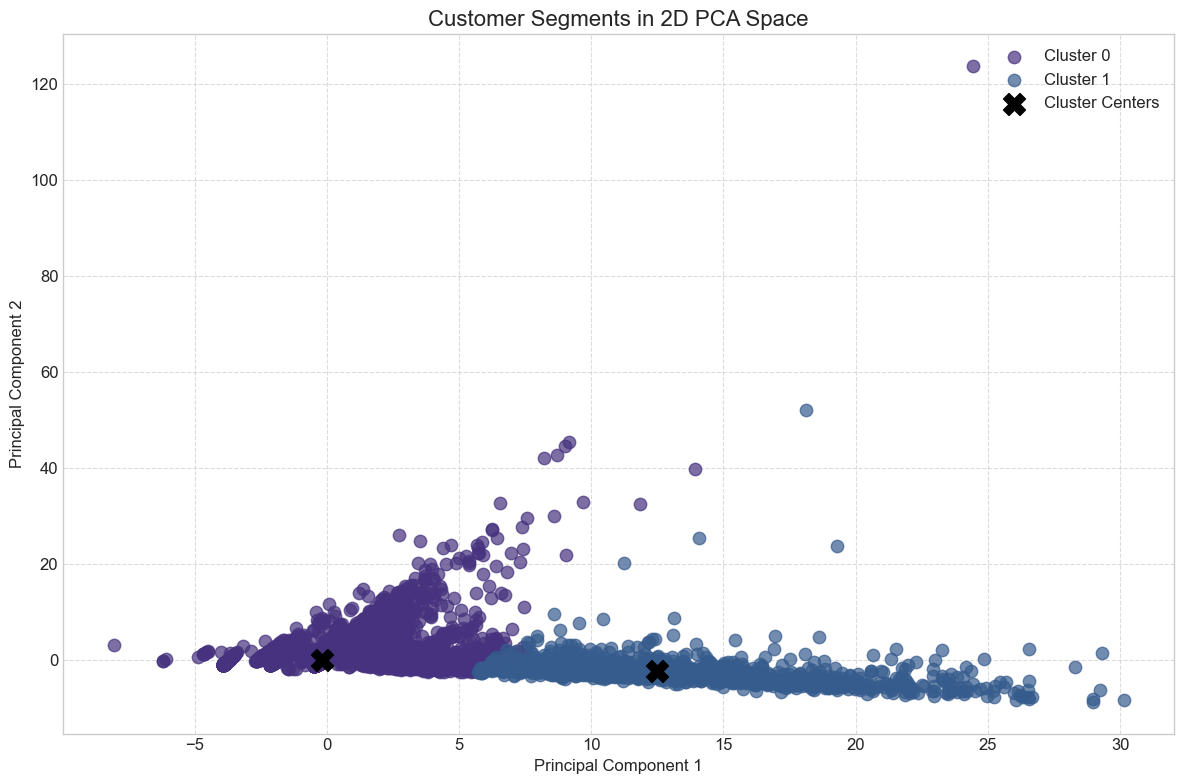

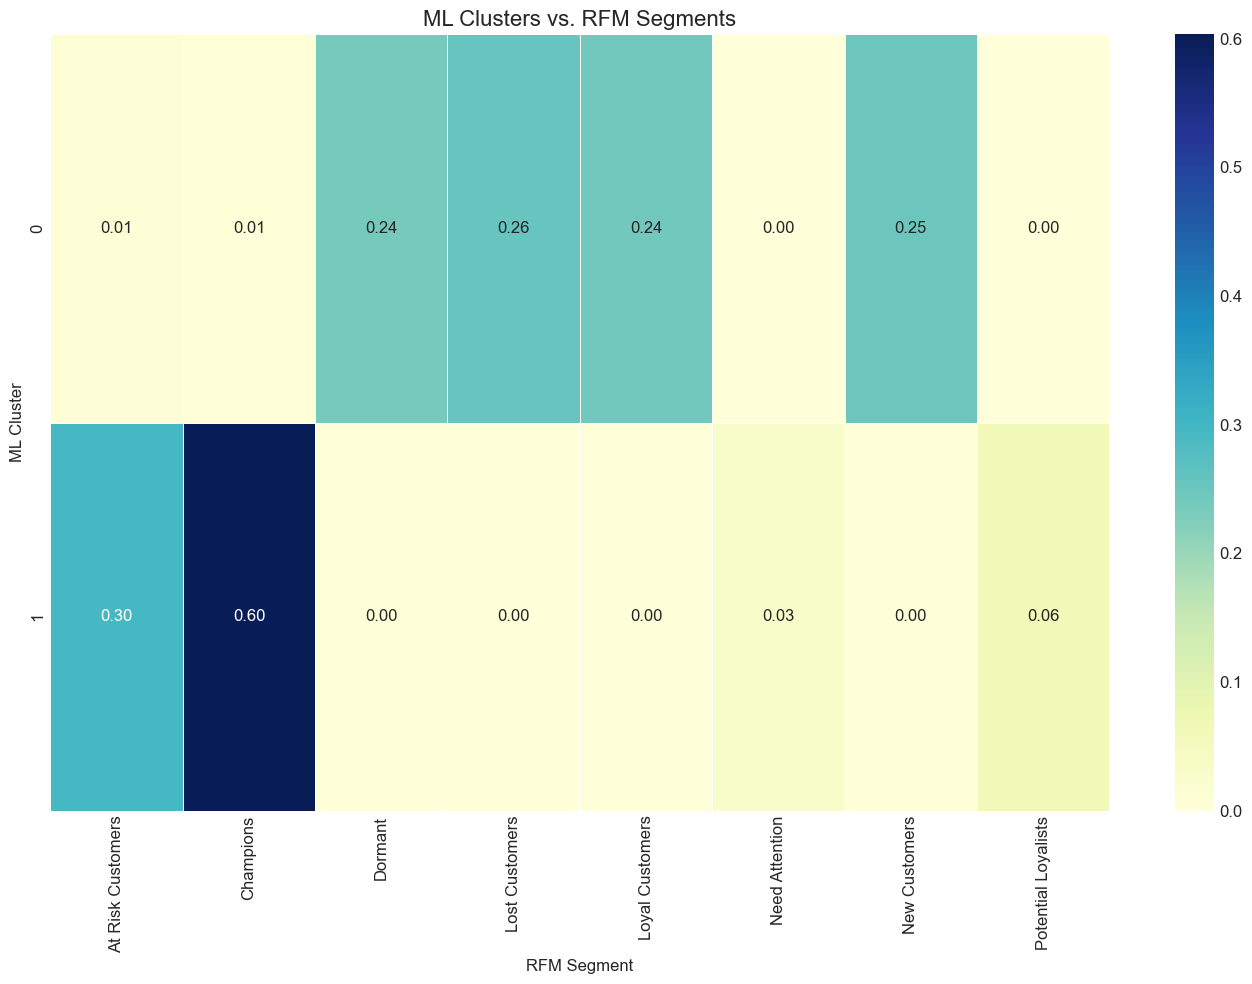


Cluster Profiles (normalized):
            monetary_per_order  total_spent_products  total_shipping_cost  \
ML_Cluster                                                                  
0                          0.0                   0.0                  0.0   
1                          1.0                   1.0                  1.0   

            avg_product_to_shipping_ratio  customer_lifetime_days  \
ML_Cluster                                                          
0                                     1.0                     0.0   
1                                     0.0                     1.0   

            purchase_frequency_monthly  unique_sellers  \
ML_Cluster                                               
0                                  1.0             0.0   
1                                  0.0             1.0   

            avg_days_between_orders  avg_installments  category_diversity  
ML_Cluster                                                               

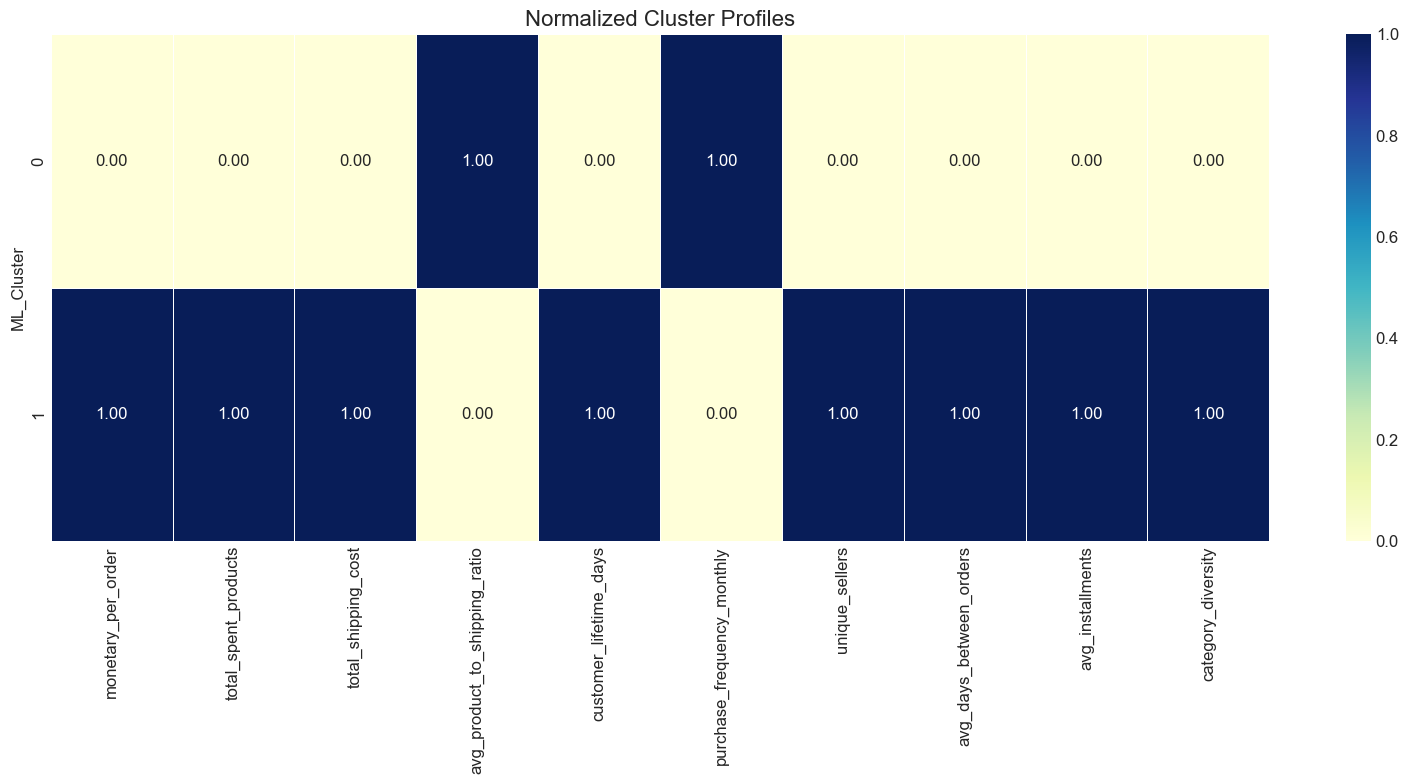

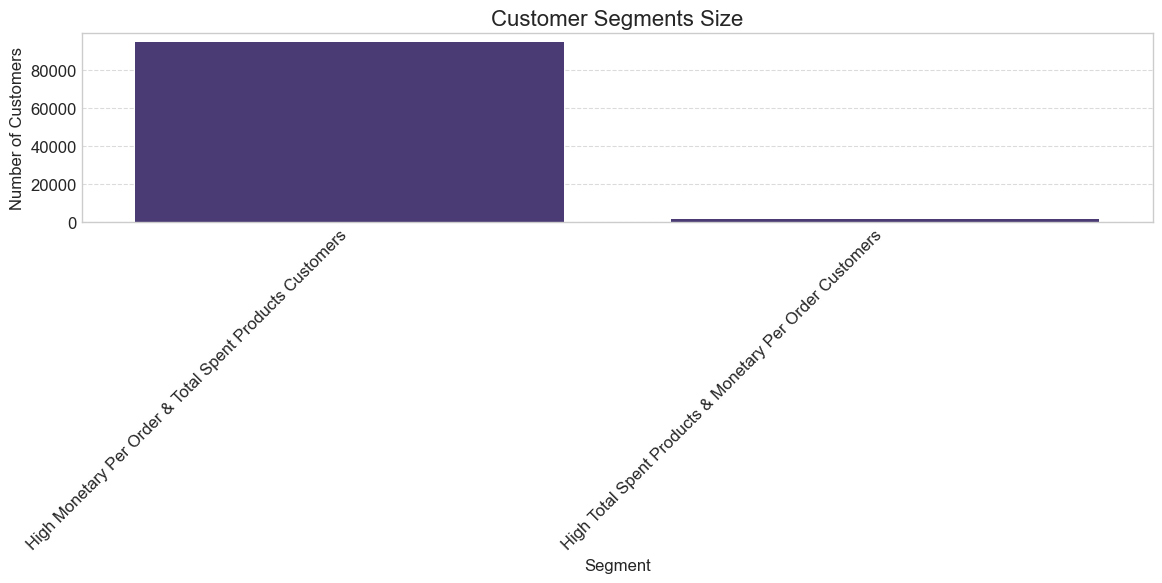

In [51]:
# Apply segmentation preparation
customer_segmented, kmeans_model, scaler_model, cluster_names = prepare_segmentation_data(customer_df_with_segments, recommended_features)

# Geographic analysis for customer segmentation

In [52]:
def perform_geographic_analysis(df, customer_df, geolocation):
   # Ensure we have geolocation data for both customers and sellers
   if 'customer_zip_code_prefix' in customer_df.columns and 'geolocation_zip_code_prefix' in geolocation.columns:
       # Get customer state distribution by segment
       if 'Cluster_Name' in customer_df.columns:
           # Join customer data with geolocation
           customer_geo = customer_df.merge(
               geolocation[['geolocation_zip_code_prefix', 'geolocation_state']].drop_duplicates(),
               left_on='customer_zip_code_prefix',
               right_on='geolocation_zip_code_prefix',
               how='left'
           )
           
           # State distribution by segment
           state_segment = pd.crosstab(
               customer_geo['geolocation_state'], 
               customer_geo['Cluster_Name'],
               normalize='columns'
           )
           
           # Plot state distribution by segment
           plt.figure(figsize=(16, 10))
           sns.heatmap(
               state_segment, 
               annot=True, 
               cmap='YlGnBu', 
               fmt='.2f',
               linewidths=0.5
           )
           plt.title('State Distribution by Customer Segment', size=16)
           plt.xlabel('Customer Segment')
           plt.ylabel('State')
           plt.tight_layout()
           plt.show()
           
           # Calculate geographic concentration for each segment
           # High concentration means customers are concentrated in fewer states
           segment_geo_concentration = {}
           
           for segment in customer_geo['Cluster_Name'].unique():
               segment_states = customer_geo[customer_geo['Cluster_Name'] == segment]['geolocation_state'].value_counts(normalize=True)
               # Calculate Herfindahl-Hirschman Index (HHI) for concentration
               hhi = np.sum(segment_states**2)
               segment_geo_concentration[segment] = hhi
           
           # Plot geographic concentration
           plt.figure(figsize=(12, 6))
           segments = list(segment_geo_concentration.keys())
           hhi_values = list(segment_geo_concentration.values())
           
           bars = plt.bar(segments, hhi_values)
           
           # Color bars by concentration level
           for i, bar in enumerate(bars):
               if hhi_values[i] > 0.5:
                   bar.set_color('darkred')  # High concentration
               elif hhi_values[i] > 0.3:
                   bar.set_color('orange')   # Medium concentration
               else:
                   bar.set_color('green')    # Low concentration (more distributed)
           
           plt.title('Geographic Concentration by Customer Segment', size=16)
           plt.xlabel('Segment')
           plt.ylabel('Concentration Index (HHI)')
           plt.xticks(rotation=45, ha='right')
           plt.grid(axis='y', linestyle='--', alpha=0.7)
           plt.tight_layout()
           plt.show()
           
           # Add concentration information to segment profiles
           print("\nGeographic Concentration by Segment:")
           for segment, hhi in segment_geo_concentration.items():
               concentration_level = "High" if hhi > 0.5 else "Medium" if hhi > 0.3 else "Low"
               print(f"{segment}: {concentration_level} concentration (HHI = {hhi:.2f})")
               
               # Top 3 states for this segment
               top_states = customer_geo[customer_geo['Cluster_Name'] == segment]['geolocation_state'].value_counts(normalize=True).head(3)
               print(f"  Top states: {', '.join([f'{state} ({pct:.1%})' for state, pct in top_states.items()])}")
           
           # Create a more detailed geographic analysis for urban vs. rural 
           # by looking at city population (approximated by customer count in each city)
           city_size = customer_geo['customer_city'].value_counts()
           
           # Classify cities by size
           large_cities = city_size[city_size >= np.percentile(city_size, 75)].index
           medium_cities = city_size[(city_size >= np.percentile(city_size, 25)) & 
                                    (city_size < np.percentile(city_size, 75))].index
           small_cities = city_size[city_size < np.percentile(city_size, 25)].index
           
           # Add city size classification to customer data
           customer_geo['city_size'] = 'Medium'
           customer_geo.loc[customer_geo['customer_city'].isin(large_cities), 'city_size'] = 'Large'
           customer_geo.loc[customer_geo['customer_city'].isin(small_cities), 'city_size'] = 'Small'
           
           # City size distribution by segment
           city_size_segment = pd.crosstab(
               customer_geo['city_size'], 
               customer_geo['Cluster_Name'],
               normalize='columns'
           )
           
           # Plot city size distribution by segment
           plt.figure(figsize=(14, 8))
           sns.heatmap(
               city_size_segment, 
               annot=True, 
               cmap='YlGnBu', 
               fmt='.2f',
               linewidths=0.5
           )
           plt.title('City Size Distribution by Customer Segment', size=16)
           plt.xlabel('Customer Segment')
           plt.ylabel('City Size')
           plt.tight_layout()
           plt.show()
           
           # Return the enhanced customer dataframe with geographic information
           return customer_geo
       else:
           print("Warning: No 'Cluster_Name' column found in customer data. Run segmentation first.")
           return customer_df
   else:
       print("Warning: Required geographic columns not found in the data.")
       return customer_df

In [53]:
# Perform geographic analysis
customer_geo_segmented = perform_geographic_analysis(df, customer_segmented, geolocation)

# Customer and segment profiling

In [54]:
def create_segment_profiles(customer_df):
   if 'Cluster_Name' not in customer_df.columns:
       print("Warning: No 'Cluster_Name' column found. Run segmentation first.")
       return None
   
   # Create comprehensive segment profiles
   segment_profiles = {}
   
   for segment in customer_df['Cluster_Name'].unique():
       segment_data = customer_df[customer_df['Cluster_Name'] == segment]
       
       # Basic counts and percentages
       segment_profiles[segment] = {
           'size': len(segment_data),
           'percentage': len(segment_data) / len(customer_df) * 100,
           
           # RFM metrics
           'avg_recency_days': segment_data['recency_days'].mean(),
           'avg_frequency': segment_data['frequency'].mean(),
           'avg_monetary': segment_data['monetary_total'].mean(),
           'avg_order_value': segment_data['avg_order_value'].mean() if 'avg_order_value' in segment_data.columns else None,
           
           # Additional metrics
           'avg_category_diversity': segment_data['category_diversity'].mean() if 'category_diversity' in segment_data.columns else None,
           'avg_customer_lifetime_days': segment_data['customer_lifetime_days'].mean() if 'customer_lifetime_days' in segment_data.columns else None,
           'avg_days_between_orders': segment_data['avg_days_between_orders'].mean() if 'avg_days_between_orders' in segment_data.columns else None,
       }
       
       # Payment preferences
       if 'preferred_payment' in segment_data.columns:
           payment_preferences = segment_data['preferred_payment'].value_counts(normalize=True)
           segment_profiles[segment]['preferred_payment'] = payment_preferences.index[0]
           segment_profiles[segment]['payment_preferences'] = dict(payment_preferences.head(3))
       
       # Location data if available
       if 'geolocation_state' in segment_data.columns:
           state_distribution = segment_data['geolocation_state'].value_counts(normalize=True)
           segment_profiles[segment]['top_states'] = dict(state_distribution.head(3))
       
       if 'city_size' in segment_data.columns:
           city_size_distribution = segment_data['city_size'].value_counts(normalize=True)
           segment_profiles[segment]['city_size_distribution'] = dict(city_size_distribution)
   
   # Convert the dictionary to a DataFrame for easier visualization
   profile_df = pd.DataFrame.from_dict(segment_profiles, orient='index')
   
   # Display basic segment profiles
   print("Customer Segment Profiles:")
   display_cols = ['size', 'percentage', 'avg_recency_days', 'avg_frequency', 
                  'avg_monetary', 'avg_order_value']
   display_cols = [col for col in display_cols if col in profile_df.columns]
   
   print(profile_df[display_cols])
   
   # Create a comprehensive segment profile report
   for segment, profile in segment_profiles.items():
       print(f"\n{'='*80}\nDETAILED PROFILE: {segment}\n{'='*80}")
       
       print(f"Size: {profile['size']} customers ({profile['percentage']:.1f}% of total)")
       print("\nRFM METRICS:")
       print(f"  Average Recency: {profile['avg_recency_days']:.1f} days since last purchase")
       print(f"  Average Frequency: {profile['avg_frequency']:.1f} orders per customer")
       print(f"  Average Monetary Value: ${profile['avg_monetary']:.2f} total spending")
       
       if profile['avg_order_value'] is not None:
           print(f"  Average Order Value: ${profile['avg_order_value']:.2f}")
       
       if profile['avg_category_diversity'] is not None:
           print(f"\nSHOPPING BEHAVIOR:")
           print(f"  Product Category Diversity: {profile['avg_category_diversity']:.1f} unique categories")
       
       if profile['avg_customer_lifetime_days'] is not None:
           print(f"  Customer Lifetime: {profile['avg_customer_lifetime_days']:.1f} days")
       
       if profile['avg_days_between_orders'] is not None:
           print(f"  Average Days Between Orders: {profile['avg_days_between_orders']:.1f} days")
       
       if 'payment_preferences' in profile:
           print("\nPAYMENT PREFERENCES:")
           for payment_type, percentage in profile['payment_preferences'].items():
               print(f"  {payment_type}: {percentage:.1%}")
       
       if 'top_states' in profile:
           print("\nGEOGRAPHIC DISTRIBUTION:")
           print("  Top States:")
           for state, percentage in profile['top_states'].items():
               print(f"    {state}: {percentage:.1%}")
       
       if 'city_size_distribution' in profile:
           print("\n  City Size Distribution:")
           for city_size, percentage in profile['city_size_distribution'].items():
               print(f"    {city_size} cities: {percentage:.1%}")
       
       print("\nRECOMMENDED MARKETING APPROACH:")
       # Custom recommendations based on segment characteristics
       if segment.lower().find('high value') >= 0:
           print("  - Loyalty programs and VIP perks to maintain high spending")
           print("  - Early access to new products and exclusive offers")
           print("  - Focus on customer retention and experience enhancement")
       elif segment.lower().find('inactive') >= 0:
           print("  - Re-engagement campaigns with special offers")
           print("  - Reminder emails about abandoned carts or viewed items")
           print("  - Surveys to understand reasons for disengagement")
       elif segment.lower().find('frequent') >= 0:
           print("  - Volume discounts to encourage larger basket sizes")
           print("  - Cross-selling campaigns to increase category diversity")
           print("  - Subscription options for frequently purchased items")
       elif segment.lower().find('big spender') >= 0:
           print("  - Premium product recommendations")
           print("  - Campaigns focused on increasing purchase frequency")
           print("  - Targeted offers based on previous high-value purchases")
       else:
           print("  - Personalized recommendations based on purchase history")
           print("  - Targeted campaigns to encourage specific behaviors")
           print("  - Regular engagement to strengthen relationship")
   
   # Create a visual summary of segments
   # Bubble chart: Size = segment size, X = avg frequency, Y = avg monetary, Color = avg recency
   plt.figure(figsize=(14, 10))
   
   bubble_sizes = profile_df['size'] / profile_df['size'].max() * 1000
   
   scatter = plt.scatter(
       profile_df['avg_frequency'],
       profile_df['avg_monetary'],
       s=bubble_sizes,
       c=profile_df['avg_recency_days'],
       cmap='viridis_r',  # Reversed so smaller recency (more recent) is darker
       alpha=0.7
   )
   
   # Add segment names as labels
   for i, segment in enumerate(profile_df.index):
       plt.annotate(
           segment,
           (profile_df['avg_frequency'].iloc[i], profile_df['avg_monetary'].iloc[i]),
           ha='center',
           va='center',
           fontsize=9,
           fontweight='bold',
           color='white' if profile_df['avg_recency_days'].iloc[i] > profile_df['avg_recency_days'].median() else 'black'
       )
   
   plt.colorbar(scatter, label='Recency (days)')
   plt.title('Customer Segment Overview', size=16)
   plt.xlabel('Average Frequency (orders)')
   plt.ylabel('Average Monetary Value ($)')
   plt.grid(True, linestyle='--', alpha=0.7)
   plt.tight_layout()
   plt.show()
   
   return profile_df

Customer Segment Profiles:
                                                     size  percentage  \
High Monetary Per Order & Total Spent Products ...  94715   98.562895   
High Total Spent Products & Monetary Per Order ...   1381    1.437105   

                                                    avg_recency_days  \
High Monetary Per Order & Total Spent Products ...        288.733632   
High Total Spent Products & Monetary Per Order ...        219.292542   

                                                    avg_frequency  \
High Monetary Per Order & Total Spent Products ...       1.017938   
High Total Spent Products & Monetary Per Order ...       2.191890   

                                                    avg_monetary  \
High Monetary Per Order & Total Spent Products ...    209.219685   
High Total Spent Products & Monetary Per Order ...    473.920456   

                                                    avg_order_value  
High Monetary Per Order & Total Spent Products ...   

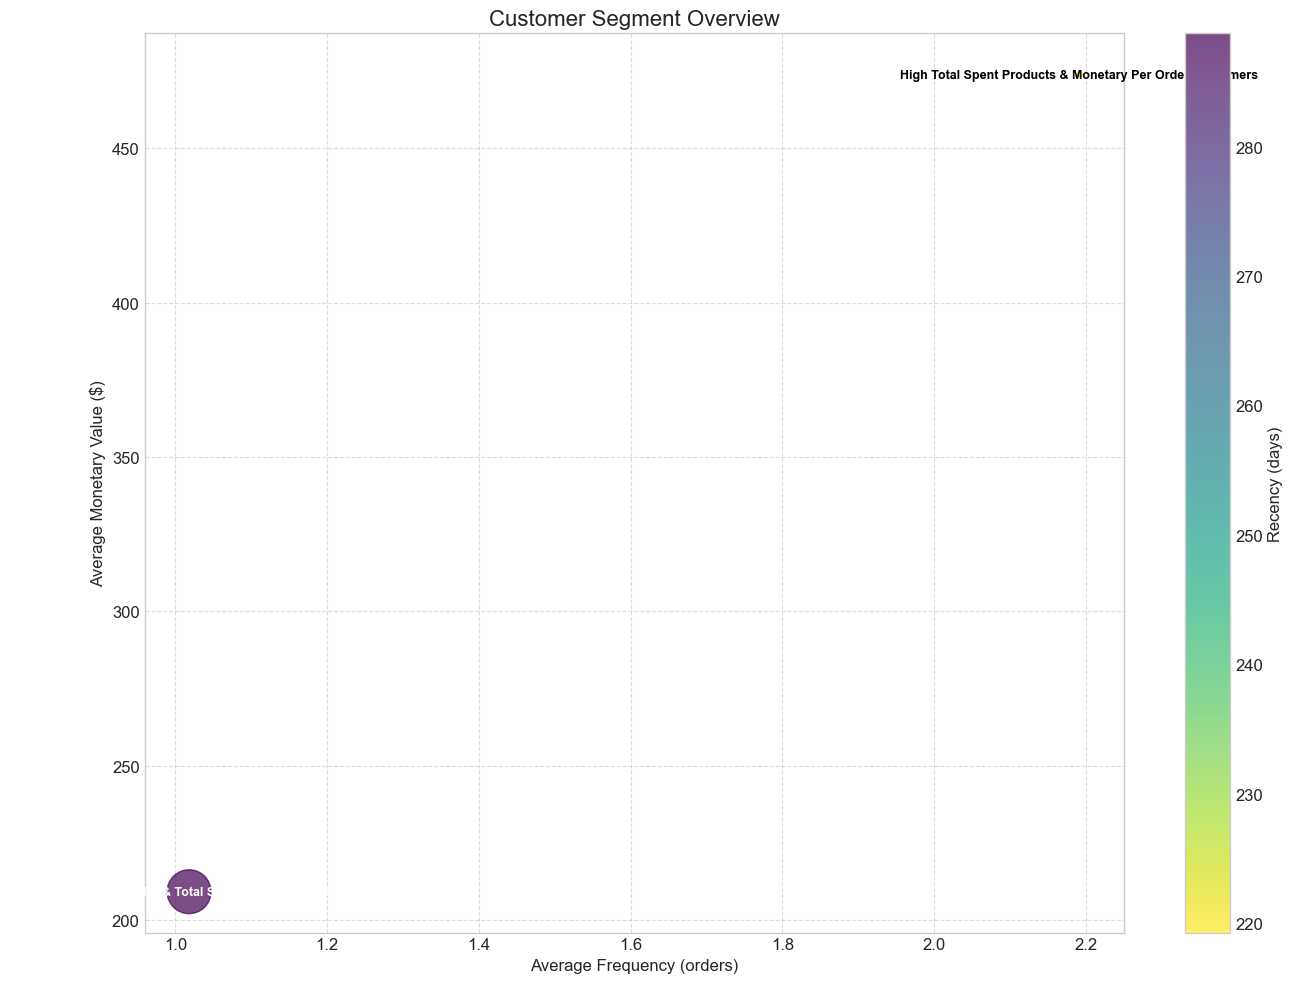

In [55]:
# Create detailed segment profiles
segment_profiles_df = create_segment_profiles(customer_geo_segmented)

# Final summary and data export

In [65]:
def finalize_segmentation(customer_df, original_df, segment_profiles_df):
    # Create a summary of the entire segmentation project
    print("\n" + "="*80)
    print("CUSTOMER SEGMENTATION SUMMARY REPORT")
    print("="*80)
    
    # Basic dataset information
    print(f"Total customers: {len(customer_df)}")
    print(f"Total orders: {original_df['order_id'].nunique()}")
    print(f"Date range: {original_df['order_purchase_timestamp'].min().strftime('%Y-%m-%d')} to {original_df['order_purchase_timestamp'].max().strftime('%Y-%m-%d')}")
    
    # Segment overview
    print("\nCUSTOMER SEGMENTS IDENTIFIED:")
    for segment, row in segment_profiles_df.iterrows():
        print(f"- {segment}: {row['size']} customers ({row['percentage']:.1f}%)")
    
    # Key insights
    print("\nKEY INSIGHTS:")
    # Calculate high-value segments (those with above average monetary value)
    high_value_segments = segment_profiles_df[segment_profiles_df['avg_monetary'] > segment_profiles_df['avg_monetary'].mean()]
    high_value_pct = high_value_segments['size'].sum() / customer_df.shape[0] * 100
    
    print(f"- {high_value_pct:.1f}% of customers are in high-value segments")
    print(f"- The highest average order value is ${segment_profiles_df['avg_order_value'].max():.2f} from the '{segment_profiles_df['avg_order_value'].idxmax()}' segment")
    
    # One-time vs returning customers
    one_time = (customer_df['frequency'] == 1).sum()
    returning = (customer_df['frequency'] > 1).sum()
    one_time_pct = one_time / len(customer_df) * 100
    
    print(f"- {one_time_pct:.1f}% of customers made only one purchase")
    
    # Identify segments with high category diversity
    if 'avg_category_diversity' in segment_profiles_df.columns:
        diverse_segments = segment_profiles_df[segment_profiles_df['avg_category_diversity'] > segment_profiles_df['avg_category_diversity'].mean()]
        print(f"- Segments with above-average product category diversity: {', '.join(diverse_segments.index.tolist())}")
    
    # Geographic insights
    if 'top_states' in segment_profiles_df.columns:
        # Find the most common top state across segments
        all_top_states = []
        for segment in segment_profiles_df.index:
            if isinstance(segment_profiles_df.loc[segment, 'top_states'], dict):
                all_top_states.extend(list(segment_profiles_df.loc[segment, 'top_states'].keys()))
        
        from collections import Counter
        common_states = Counter(all_top_states).most_common(3)
        print(f"- Most common top states across all segments: {', '.join([state for state, count in common_states])}")
    
    # Export the segmented customer data to CSV
    current_date = pd.Timestamp.now().strftime("%Y%m%d")
    export_filename = f"olist_customer_segments_{current_date}.csv"
    
    try:
        customer_df.to_csv(export_filename, index=False)
        print(f"\nExported segmented customer data to {export_filename}")
    except Exception as e:
        print(f"\nError exporting data: {e}")
    
    # Create a dictionary of actionable recommendations for each segment
    segment_recommendations = {}
    
    for segment in customer_df['Cluster_Name'].unique():
        if 'high value' in segment.lower():
            segment_recommendations[segment] = [
                "Implement a VIP loyalty program with exclusive perks",
                "Offer early access to new products and collections",
                "Provide personalized customer service and dedicated account managers",
                "Send regular 'thank you' communications with special offers",
                "Focus on cross-selling complementary premium products"
            ]
        elif 'inactive' in segment.lower():
            segment_recommendations[segment] = [
                "Launch a win-back campaign with special discounts",
                "Send a customer survey to understand reasons for inactivity",
                "Create abandoned cart or 'we miss you' email sequences",
                "Highlight new products or improvements since their last purchase",
                "Test different incentives to identify what reactivates this segment"
            ]
        elif 'frequent' in segment.lower():
            segment_recommendations[segment] = [
                "Create a subscription or auto-ship program for frequently purchased items",
                "Provide volume discounts to encourage larger purchases",
                "Implement a points system that rewards purchase frequency",
                "Focus on expanding category diversity through targeted recommendations",
                "Create bundle offers for complementary products"
            ]
        elif 'big spender' in segment.lower() or 'big spenders' in segment.lower():
            segment_recommendations[segment] = [
                "Curate premium product collections and exclusive offerings",
                "Implement price anchoring with high-end products",
                "Provide white-glove delivery services or premium shipping options",
                "Create campaigns focused on increasing purchase frequency",
                "Develop a referral program with premium incentives"
            ]
        else:
            segment_recommendations[segment] = [
                "Personalize communications based on purchase history",
                "Implement targeted campaigns to encourage desired behaviors",
                "Use product recommendations based on segment preferences",
                "Test different marketing messages to improve engagement",
                "Create segment-specific promotions for products they're likely to buy"
            ]
    
    # Print actionable recommendations
    print("\nACTIONABLE RECOMMENDATIONS:")
    for segment, recommendations in segment_recommendations.items():
        print(f"\nFor {segment}:")
        for i, rec in enumerate(recommendations, 1):
            print(f"  {i}. {rec}")
    
    # Next steps for implementation
    print("\nNEXT STEPS:")
    print("1. Implement the segmentation model in production systems")
    print("2. Set up automated customer assignment to segments based on behavior")
    print("3. Create segment-specific marketing campaigns and journeys")
    print("4. Establish KPIs to track segment performance and movement")
    print("5. Set up regular reviews to refine segmentation model and strategies")
    
    return segment_recommendations

In [66]:
# Create final summary and export results
segment_recommendations = finalize_segmentation(customer_geo_segmented, df, segment_profiles_df)


CUSTOMER SEGMENTATION SUMMARY REPORT
Total customers: 96096
Total orders: 99441
Date range: 2016-09-04 to 2018-10-17

CUSTOMER SEGMENTS IDENTIFIED:
- High Monetary Per Order & Total Spent Products Customers: 94715 customers (98.6%)
- High Total Spent Products & Monetary Per Order Customers: 1381 customers (1.4%)

KEY INSIGHTS:
- 1.4% of customers are in high-value segments
- The highest average order value is $126.79 from the 'High Monetary Per Order & Total Spent Products Customers' segment
- 96.9% of customers made only one purchase
- Segments with above-average product category diversity: High Total Spent Products & Monetary Per Order Customers

Exported segmented customer data to olist_customer_segments_20250519.csv

ACTIONABLE RECOMMENDATIONS:

For High Monetary Per Order & Total Spent Products Customers:
  1. Personalize communications based on purchase history
  2. Implement targeted campaigns to encourage desired behaviors
  3. Use product recommendations based on segment pref

In [68]:
def export_for_power_bi(customer_df, original_df, segment_profiles_df=None):
    """
    Export all necessary data files for Power BI visualization.
    
    Parameters:
    -----------
    customer_df : DataFrame
        The customer dataframe with segmentation data
    original_df : DataFrame
        The original orders dataframe
    segment_profiles_df : DataFrame, optional
        The segment profiles summary dataframe
    """
    current_date = pd.Timestamp.now().strftime("%Y%m%d")
    export_files = []
    
    try:
        # 1. Main customer segments data
        export_filename = f"olist_customer_segments_{current_date}.csv"
        
        # Get columns that exist in the dataframe
        potential_columns = [
            'customer_unique_id', 'ML_Cluster', 'Cluster_Name', 'Customer_Segment',
            'recency_days', 'frequency', 'monetary_total', 'avg_order_value',
            'category_diversity', 'customer_lifetime_days', 'avg_days_between_orders',
            'preferred_payment', 'customer_city', 'customer_state', 'customer_zip_code_prefix'
        ]
        
        # Filter to columns that actually exist
        viz_columns = [col for col in potential_columns if col in customer_df.columns]
        
        # Export main customer data
        customer_df[viz_columns].to_csv(export_filename, index=False)
        print(f"✓ Exported segmented customer data to {export_filename}")
        export_files.append(export_filename)
        
        # 2. Segment profile summary
        if segment_profiles_df is not None:
            segment_summary_file = f"olist_segment_profiles_{current_date}.csv"
            segment_profiles_df.reset_index().rename(columns={'index': 'segment_name'}).to_csv(segment_summary_file, index=False)
            print(f"✓ Exported segment profiles summary to {segment_summary_file}")
            export_files.append(segment_summary_file)
        
        # 3. State/region distribution by segment
        if 'customer_state' in customer_df.columns and 'Cluster_Name' in customer_df.columns:
            geo_segment_file = f"olist_segment_geography_{current_date}.csv"
            
            # Count customers by segment and state
            geo_segment_summary = customer_df.groupby(['Cluster_Name', 'customer_state']).size().reset_index(name='customer_count')
            
            # Add percentage within segment
            segment_totals = geo_segment_summary.groupby('Cluster_Name')['customer_count'].sum().reset_index()
            segment_totals.rename(columns={'customer_count': 'segment_total'}, inplace=True)
            
            geo_segment_summary = geo_segment_summary.merge(segment_totals, on='Cluster_Name')
            geo_segment_summary['percentage_of_segment'] = (geo_segment_summary['customer_count'] / 
                                                           geo_segment_summary['segment_total'] * 100)
            
            geo_segment_summary.to_csv(geo_segment_file, index=False)
            print(f"✓ Exported geographic segment summary to {geo_segment_file}")
            export_files.append(geo_segment_file)
        
        # 4. Customer-order details with segment
        if 'order_purchase_timestamp' in original_df.columns and 'customer_unique_id' in original_df.columns:
            # Create a simplified order summary
            order_summary = original_df.groupby('customer_unique_id').agg({
                'order_id': 'nunique',
                'order_purchase_timestamp': ['min', 'max'],
                'payment_value': ['sum', 'mean']
            })
            
            # Flatten the column names
            order_summary.columns = ['_'.join(col).strip('_') for col in order_summary.columns.values]
            
            # Rename columns for clarity
            order_summary.rename(columns={
                'order_id_nunique': 'total_orders',
                'order_purchase_timestamp_min': 'first_purchase_date',
                'order_purchase_timestamp_max': 'last_purchase_date',
                'payment_value_sum': 'total_spend',
                'payment_value_mean': 'avg_order_value'
            }, inplace=True)
            
            # Add days since first and last purchase
            max_date = original_df['order_purchase_timestamp'].max()
            order_summary['days_since_first_purchase'] = (max_date - order_summary['first_purchase_date']).dt.days
            order_summary['days_since_last_purchase'] = (max_date - order_summary['last_purchase_date']).dt.days
            
            # Reset index
            order_summary = order_summary.reset_index()
            
            # Add segment information
            if 'Cluster_Name' in customer_df.columns:
                order_summary = order_summary.merge(
                    customer_df[['customer_unique_id', 'Cluster_Name']], 
                    on='customer_unique_id', 
                    how='left'
                )
            
            # Export order summary
            order_summary_file = f"olist_order_summary_{current_date}.csv"
            order_summary.to_csv(order_summary_file, index=False)
            print(f"✓ Exported order summary data to {order_summary_file}")
            export_files.append(order_summary_file)
        
        # 5. Product category performance by segment
        if 'product_category_name_english' in original_df.columns and 'customer_unique_id' in original_df.columns:
            # Get clusters for each customer
            customer_clusters = customer_df[['customer_unique_id', 'Cluster_Name']]
            
            # Merge with original data
            product_data = original_df.merge(customer_clusters, on='customer_unique_id', how='left')
            
            # Aggregate by product category and segment
            category_segment = product_data.groupby(['product_category_name_english', 'Cluster_Name']).agg({
                'order_id': 'nunique',
                'price': ['sum', 'mean'],
                'customer_unique_id': 'nunique'
            }).reset_index()
            
            # Flatten columns
            category_segment.columns = ['_'.join(col).strip('_') if isinstance(col, tuple) else col 
                                       for col in category_segment.columns]
            
            # Rename columns
            category_segment.rename(columns={
                'order_id_nunique': 'order_count',
                'price_sum': 'total_revenue',
                'price_mean': 'avg_price',
                'customer_unique_id_nunique': 'customer_count'
            }, inplace=True)
            
            # Export product category performance
            category_file = f"olist_category_segment_{current_date}.csv"
            category_segment.to_csv(category_file, index=False)
            print(f"✓ Exported product category by segment data to {category_file}")
            export_files.append(category_file)
        
        # 6. Date dimension table
        if 'order_purchase_timestamp' in original_df.columns:
            # Create date range
            min_date = pd.to_datetime(original_df['order_purchase_timestamp']).min()
            max_date = pd.to_datetime(original_df['order_purchase_timestamp']).max()
            
            # Create date dimension table (Power BI loves this for time intelligence)
            date_range = pd.date_range(start=min_date, end=max_date)
            date_dim = pd.DataFrame({
                'date_key': date_range,
                'full_date': date_range.strftime('%Y-%m-%d'),
                'year': date_range.year,
                'quarter': date_range.quarter,
                'month': date_range.month,
                'month_name': date_range.strftime('%B'),
                'day': date_range.day,
                'day_of_week': date_range.dayofweek,
                'day_name': date_range.strftime('%A'),
                'is_weekend': date_range.dayofweek.isin([5, 6]).astype(int)
            })
            
            # Export date dimension
            date_dim_file = f"olist_date_dimension_{current_date}.csv"
            date_dim.to_csv(date_dim_file, index=False)
            print(f"✓ Exported date dimension table to {date_dim_file}")
            export_files.append(date_dim_file)
        
        print(f"\nSuccessfully exported {len(export_files)} files for Power BI visualization.")
        
    except Exception as e:
        print(f"Error exporting data: {e}")
    
    return export_files

In [69]:
exported_files = export_for_power_bi(
    customer_df=customer_geo_segmented,
    original_df=df,
    segment_profiles_df=segment_profiles_df
)

✓ Exported segmented customer data to olist_customer_segments_20250519.csv
✓ Exported segment profiles summary to olist_segment_profiles_20250519.csv
✓ Exported order summary data to olist_order_summary_20250519.csv
✓ Exported product category by segment data to olist_category_segment_20250519.csv
✓ Exported date dimension table to olist_date_dimension_20250519.csv

Successfully exported 5 files for Power BI visualization.
